***
*Project:* The Helmholtz Machine

*Author:* Jingwei Liu, Computer Music Ph.D., UC San Diego
***

# <span style="background-color:darkorange; color:white; padding:2px 6px">Document 1</span> 

# Modern Helmholtz Machine

*Created:* April 3, 2025

The modified Helmholtz machine structure is given below:

<img src="Modern.jpg" style="width:800px">
<caption><center> **Figure 1**: Modern Helmholtz Machine. Blue neurons represent instantiation layers, where the neurons take binary values. Orange neurons indicate the inserted activations, where the neurons take value in real numbers in given range.    </center></caption>

In [284]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import torch
torch.cuda.is_available()

True

In [285]:
dev = torch.device('cuda')

Notation on data:
- Dataset $D$: random variable, the goal is to (implicitly) maximize evidence $P(D)$
- Phenotype layer $d_0$: single data input, observable state
- $d$: single data point, observable variable

Notation on hidden layers:
- $z_i$: $i$-th instantiated hidden layer, random variable.
- $s_i$: value assignment of $i$-th instantiated hidden layer, hidden state
- $q(z_i[k])$: probability of $k$-th neuron in $z_i$ in recognition process
- $p(z_i[k])$: probability of $k$-th neuron in $z_i$ in generative process
- $q(z_i)$: probability of $z_i$ in recognition process, since the sampling of neurons are independent, $q(z_i) = \prod_k q(z_i[k])$
- $p(z_i)$: probability of $z_i$ in generative process, since the sampling of neurons are independent, $p(z_i) = \prod_k p(z_i[k])$
- $l^{i,i+1}_j$: $j$-th inserted hidden layers between $z_i$ and $z_{i+1}$, multilayer perceptron

Parameters (amortized):
- $\Phi$: recognition weights, compute neuron values bottom-up in wake phase.
- $\Theta$: generative weights, compute neuron values top-down in sleep phase.

#### Define model structure

n_dz -- number of neurons for each layer, numpy array of shape (n+1,m), where m is the number of instantiation layers, 
n is the maximum number of inserted layers between adjacent instantiation layers.

A neural network in Figure 1 has structure ndarray:
$$
n_{dz} = 
\begin{pmatrix}
10 & 8 & 6 & 3 & 1 \\
9 & 0 & 5 & 0 & 0 \\
0 & 0 & 4 & 0 & 0  \\
\end{pmatrix}
$$

The first row gives the number of neurons in each instantiation layer. The second row represents the first inserted layer, and there is a 9-neuron layer inserted between $d_0$ and $z_1$, a 5-neuron layer inserted between $z_2$ and $z_3$. The third row represents the second inserted layer, and there is only one 4-neuron layer inserted between $z_2$ and $z_3$ above the first 5-neuron inserted layer. Obviously, $n_{dz}(i,k) \ne 0$ if and only if $n_{dz}(i,j) \ne 0, \forall j < k$; the last column of  $n_{dz}$ is all zero except for the value in the first row.

In [286]:
structure = [[10,8,6,3,1],
             [9, 0,5,0,0],
             [0, 0,4,0,0]]
n_dz = torch.tensor(structure)
n_dz

tensor([[10,  8,  6,  3,  1],
        [ 9,  0,  5,  0,  0],
        [ 0,  0,  4,  0,  0]])

In [287]:
def para_init(n_dz,dev):
    """
    Arguments:
    n_dz -- torch tensor of shape (n_mlp_max, n_smp). n_mlp_max is the maximum number of MLP layers. 
            n_smp is the number of sampled layers
    dev -- torch device

    Returns:
    Phi, Theta -- set of parameters (random initialization) for hierarchical layers. len(Phi) = n_smp-2. len(Theta) = n_smp-1.
    """
    Phi = {}
    Theta = {}
    n_smp = n_dz.shape[1]
    for i in range(n_smp-2):
        n_mlp = len(torch.where(n_dz[:,i] != 0)[0])
        Phi["Phi_" + str(i) + str(i+1)] = {}
        for j in range(n_mlp-1):
            Phi["Phi_" + str(i) + str(i+1)][j] = torch.rand(n_dz[j+1,i],n_dz[j,i],device=dev)
        Phi["Phi_" + str(i) + str(i+1)][n_mlp-1] = torch.rand(n_dz[0,i+1],n_dz[n_mlp-1,i],device=dev)
    for i in range(n_smp-1,0,-1):
        n_mlp = len(torch.where(n_dz[:,i-1] != 0)[0])
        Theta["Theta_" + str(i) + str(i-1)] = {}
        Theta["Theta_" + str(i) + str(i-1)][0] = torch.rand(n_dz[n_mlp-1,i-1],n_dz[0,i],device=dev)
        for j in range(n_mlp-1):
            Theta["Theta_" + str(i) + str(i-1)][j+1] = torch.rand(n_dz[n_mlp-j-2,i-1],n_dz[n_mlp-j-1,i-1],device=dev)
    return Phi,Theta

In [288]:
def sigmoid(x):
    """
    Arguments:
    x -- torch tensor of shape (n,batch_size)
    
    Returns:
    p -- probability of layer y, torch tensor of shape (n,batch_size)
    """
    p = 1/(1+torch.exp(-x))
    return p

In [289]:
def one_step_forward(x,param):
    """
    Arguments:
    x -- input layer, torch tensor of shape (n_x,batch_size)
    param -- parameters from x to y. Torch tensor of shape (n_y,n_x)
    
    Returns:
    q -- probability of layer y, torch tensor of shape (n_y,batch_size)
    """
    q = sigmoid(torch.matmul(param,x.type(torch.float)))
    return q

In [290]:
def layer_step_forward(x,param):
    """
    Arguments:
    x -- input layer, torch tensor of shape (n_x,batch_size)
    param -- parameters from x to y. Python dictionary of length n_mlp, of keys 0,1,2,...
    
    Returns:
    q -- probability of sample layer y, torch tensor of shape (n_y,batch_size)
    """
    n_mlp = len(param)
    q = x
    for i in range(n_mlp):
        q = one_step_forward(q,param[i])
    return q

In [291]:
def sample(q,dev):
    """
    Arguments:
    q -- probability of layer y, torch tensor of shape (n_y,batch_size)
    dev -- device
    
    Returns:
    y -- instantiation of layer y, torch tensor of shape (n_y,batch_size)
    """
    y = (q > torch.rand(q.size(),device=dev)).long() # rejection sampling
    return y

In [292]:
def log(p):
    q = torch.where(p != 0, torch.log(p), -20) # replace log(0) with -100
    return q

In [293]:
def cross_entropy_loss(y,q):
    """
    Arguments:
    y -- output layer sample, torch tensor of shape (n_y,batch_size)
    q -- probability of layer y, torch tensor of shape (n_y,batch_size)
    
    Returns:
    loss -- cross entropy loss, L = -(y.*log(q)+(1-y).*log(1-q)).mean()
    """
    loss = -(y * log(q) + (1-y) * log(1-q)).mean()
    return loss

In [294]:
def one_step_update(x,y,param,lr):
    """
    Arguments:
    x -- input layer sample, torch tensor of shape (n_x,batch_size)
    y -- output layer sample, torch tensor of shape (n_y,batch_size)
    param -- parameters from x to y. Python dictionary of length n_mlp, of keys 0,1,2,...
    lr -- learning rate
    
    Returns:
    param -- updated parameters from x to y.
    loss -- cross entropy loss, L = -(y.*log(q)+(1-y).*log(1-q)).mean()
    Q -- the activations of each layer. Bernoulli probabilities. Python dictionary of length n_mlp, of keys 0,1,2,...
    """
    batch_size = x.shape[1]
    n_mlp = len(param)
    Q = {}    # activation/ probability
    q = x
    for i in range(n_mlp):
        Q[i] = one_step_forward(q,param[i])
        q = Q[i]
    u = Q[n_mlp-1] - y # (n_y,batch_size)
    loss = cross_entropy_loss(y,Q[n_mlp-1])
    for i in range(n_mlp-1,0,-1):
        dW = torch.matmul(u,torch.t(Q[i-1]))/batch_size
        dz = torch.matmul(torch.t(param[i]),u) # (n_z,batch_size)
        param[i] -= lr*dW
        u = dz * Q[i-1] * (1-Q[i-1])
    dW_x = torch.matmul(u,torch.t(x.type(torch.float)))/batch_size
    param[0] -= lr*dW_x
    return param, loss, Q

In [295]:
def layer_wise_train(input_x,param_xy,param_yx,lr):
    """
    Arguments:
    input_x -- input layer sample, torch tensor of shape (n_x,batch_size)
    param_xy -- parameters from x to y. Python dictionary of length n_mlp, of keys 0,1,2,...
    param_yx -- parameters from y to x. Python dictionary of length n_mlp, of keys 0,1,2,...
    lr -- learning rate
    
    Returns:
    output_y -- output layer sample, torch tensor of shape (n_y,batch_size)
    param_yx -- updated parameters from y to x
    loss -- cross entropy loss at layer x
    """
    
    # Compute output layer distribution
    q = layer_step_forward(input_x,param_xy)
    
    # Sample the output layer
    output_y = sample(q,dev)
    
    # train the opposite phase from x to y
    param_yx, loss, Q = one_step_update(output_y,input_x,param_yx,lr)
    
    return output_y, param_yx, loss

In [296]:
def wake_phase(Phi,Theta,data,lr,dev):
    """
    Arguments:
    Phi -- set of bottom-up parameters for hierarchical layers. len(Phi) = n_layer-2
    Theta -- set of top-down parameters for hierarchical layers. len(Theta) = n_layer-1
    data -- input data. Torch tensor of shape (n_d,batch_size)
    lr -- learning rate
    dev -- torch device
    
    Returns:
    Theta -- updated sleep phase parameters.
    Loss -- layer-wise loss bottom-up. Torch tensor of shape (n_layer-1,)
    """
    n_layer = len(Theta) + 1
    Loss = torch.zeros(n_layer-1)
    batch_size = data.shape[1]
    input_x = data
    for i in range(n_layer-2):
        output_y, Theta["Theta_" + str(i+1) + str(i)], Loss[i] = \
        layer_wise_train(input_x,Phi["Phi_" + str(i) + str(i+1)],Theta["Theta_" + str(i+1) + str(i)],lr)
        input_x = output_y
    Theta["Theta_" + str(n_layer-1) + str(n_layer-2)], Loss[n_layer-2], Q = \
    one_step_update(torch.ones(1,batch_size,dtype=int,device=dev),input_x,Theta["Theta_" + str(n_layer-1) + str(n_layer-2)],lr)
    return Theta, Loss

In [297]:
def wake_sample(Phi,data,dev):
    """
    Arguments:
    Phi -- set of bottom-up parameters for hierarchical layers. len(Phi) = n_layer-2
    data -- input data. Torch tensor of shape (n_d,batch_size)
    dev -- torch device
    
    Returns:
    Recog_sample -- set of bottom-up samples for hierarchical layers. len(Recog_sample) = n_layer-2. For every layer, 
    """
    n_layer = len(Phi) + 2
    batch_size = data.shape[1]
    input_x = data
    Recog_sample = {}
    Recog_sample["Layer_" + str(0)] = data
    for i in range(n_layer-2):
        input_x = sample(layer_step_forward(input_x,Phi["Phi_" + str(i) + str(i+1)]),dev)
        Recog_sample["Layer_" + str(i+1)] = input_x
    return Recog_sample

In [298]:
def sleep_phase(Phi,Theta,gen_batch_size,lr,dev):
    """
    Arguments:
    Phi -- set of bottom-up parameters for hierarchical layers. len(Phi) = n_layer-2
    Theta -- set of top-down parameters for hierarchical layers. len(Theta) = n_layer-1
    gen_batch_size -- number of generated samples in a batch
    lr -- learning rate
    dev -- torch device
    
    Returns:
    Phi -- updated sleep phase parameters.
    Loss -- layer-wise loss bottom-up. Torch tensor of shape (n_layer-1,)
    """
    n_layer = len(Theta) + 1
    Loss = torch.zeros(n_layer-1)
    unit = torch.ones(1,gen_batch_size,dtype=int,device=dev)
    input_x = sample(layer_step_forward(unit,Theta["Theta_" + str(n_layer-1) + str(n_layer-2)]),dev)
    for i in range(n_layer-2,0,-1):
        output_y, Phi["Phi_" + str(i-1) + str(i)], Loss[i] = \
        layer_wise_train(input_x,Theta["Theta_" + str(i) + str(i-1)],Phi["Phi_" + str(i-1) + str(i)],lr)
        input_x = output_y
    return Phi, Loss

In [299]:
def sleep_sample(Theta,gen_batch_size,dev):
    """
    Arguments:
    Theta -- set of top-down parameters for hierarchical layers. len(Theta) = n_layer-1
    gen_batch_size -- number of generated samples in a batch
    dev -- torch device
    
    Returns:
    Gen_sample -- set of top-down generations for hierarchical layers. len(Gen_sample) = n_layer-1. For every layer, 
                    gen_sample is of shape (n_y, gen_batch_size)
    """
    n_layer = len(Theta) + 1
    input_x = torch.ones(1,gen_batch_size,dtype=int,device=dev)
    Gen_sample = {}
    for i in range(n_layer-1,0,-1):
        input_x = sample(layer_step_forward(input_x,Theta["Theta_" + str(i) + str(i-1)]),dev)
        Gen_sample["Layer_" + str(i-1)] = input_x
    return Gen_sample

In [300]:
def decimalize(bnr,dev):
    """
    Arguments: bnr -- torch tensor of binary values {0,1}, of shape (width,n)
    Returns: dcm -- a decimalized intger tensor in range [0,2**width), shape (n,)
    """
    width = bnr.shape[0]
    dcm = (2**torch.arange(width).flip(0).to(dev).reshape(-1,1) * bnr).sum(axis=0)
    return dcm

In [301]:
def binarilize(dcm,width,dev):
    """
    Arguments: dcm -- a decimalized intger tensor in range [0,2**width), shape (n,)
    Returns:   bnr -- torch tensor of binary values {0,1}, of shape (width,n)
    """
    n = len(dcm)
    bnr = np.zeros((width,n),dtype=int)
    for i in range(n):
        bnr[:,i:i+1] = np.array(list(np.binary_repr(dcm[i], width=width))).astype(int).reshape(-1,1)
    bnr = torch.from_numpy(bnr).type(torch.int64).to(dev)
    return bnr

In [302]:
def entropy(row_dist):
    """
    Arguments: row_dist -- unnormalized row distribution. Torch tensor of shape (n_row, n_p) or (n_p,)
    Returns: H -- row entropy. Torch tensor of shape (n_row,1) or a number
    """
    if row_dist.ndim == 1:
        p = row_dist/row_dist.sum()
        H = (-p * log(p)).sum()
    else:
        P = row_dist/row_dist.sum(axis=1,keepdims=True)
        H = (-P * log(P)).sum(axis=1,keepdims=True)
    return H

In [303]:
def entropy_bernoulli(P_ber):
    """
    Arguments: P_ber -- multi-variate independent row Bernoulli distributions. Torch tensor of shape (n_row, n_p) or (n_p,)
    Returns: H_ber -- row Bernoulli entropy. Torch tensor of shape (n_row,1) or a number
    """
    entropy = - (P_ber * log(P_ber) + (1-P_ber) * log(1-P_ber))
    if P_ber.ndim == 1:
        H_ber = entropy.sum()
    else:
        H_ber = entropy.sum(axis=1,keepdims=True)
    return H_ber

In [304]:
def KL_divergence(p,q):
    """
    Arguments: probability distribution p,q. Torch tensors of shape (n,)
    Returns: KL-divergence (p*log(p/q)).sum()
    """
    if (p.ndim == 1) and (q.ndim == 1):
        D_KL = (p*log(p) - p*log(q)).sum()
    else:
        raise Exception('Dimension error')
    return D_KL

In [305]:
def KL_divergence_bernoulli(p,q):
    """
    Arguments: multi-variate independent Bernoulli distributions. Torch tensors of shape (n,)
    Returns: sum of n bernoulli variable KL-divergence (p*log(p/q)+(1-p)*log((1-p)/(1-q))).sum()
    """
    if (p.ndim == 1) and (q.ndim == 1):
        D_KL_bernoulli = (p*log(p) - p*log(q) + (1-p)*log(1-p) - (1-p)*log(1-q)).sum()
    else:
        raise Exception('Dimension error')
    return D_KL_bernoulli

In [306]:
def one_step_prob_entropy(q):
    """
    Arguments:
    q -- probability of layer y, torch tensor of shape (n_y,batch_size)
    
    Returns:
    p_y -- Bernoulli probability of each neuron at layer Y. Torch tensor of shape (n_y,)
    H_Y -- factorial entropy at output layer Y, a tensor number
    I -- mutual information between layers X and Y, a tensor number
    """
    p_yx = q.t()   # (batch_size,n_y)
    H_YX = entropy_bernoulli(p_yx).mean() # tensor number
    p_y = p_yx.mean(axis=0) # (n_y,)
    H_Y = entropy_bernoulli(p_y) # tensor number
    I = H_Y - H_YX
    return H_Y, I

In [307]:
def wake_entropy(Phi,data,dev):
    """
    Arguments:
    Phi -- set of bottom-up parameters for hierarchical layers. len(Phi) = n_layer-2
    data -- input data. Torch tensor of shape (n_d,batch_size)
    dev -- torch device
    
    Returns:
    H_Y_wake -- factorial entropy at layers 1,...,n_layer-2. Torch tensor of shape (n_layer-2,)
    I_wake -- mutual information between layers [0,1],...,[n_layer-3,n_layer-2]. Torch tensor of shape (n_layer-2,)
    """
    n_layer = len(Phi) + 2
    H_Y_wake = torch.zeros(n_layer-2)
    I_wake = torch.zeros(n_layer-2)
    input_x = data
    for i in range(n_layer-2):
        q = layer_step_forward(input_x,Phi["Phi_" + str(i) + str(i+1)])
        H_Y_wake[i], I_wake[i] = one_step_prob_entropy(q)
        input_x = sample(q,dev)
    return H_Y_wake, I_wake

In [308]:
def sleep_entropy(Theta,gen_batch_size,dev):
    """
    Arguments:
    Theta -- set of top-down parameters for hierarchical layers. len(Theta) = n_layer-1
    gen_batch_size -- number of generated samples in a batch
    dev -- torch device
    
    Returns:
    H_Y_sleep -- factorial entropy at layers 0,...,n_layer-2. Torch tensor of shape (n_layer-2,)
    I_sleep -- mutual information between layers [1,0],...,[n_layer-2,n_layer-3]. Torch tensor of shape (n_layer-2,)
    """
    n_layer = len(Theta) + 1
    H_Y_sleep = torch.zeros(n_layer-1)
    I_sleep = torch.zeros(n_layer-1)
    input_x = torch.ones(1,gen_batch_size,dtype=int,device=dev)
    for i in range(n_layer-1,0,-1):
        q = layer_step_forward(input_x,Theta["Theta_" + str(i) + str(i-1)])
        H_Y_sleep[i-1], I_sleep[i-1] = one_step_prob_entropy(q)
        input_x = sample(q,dev)
    I_sleep = I_sleep[:-1]
    return H_Y_sleep, I_sleep

## Mutual Information Maximization
Linear approximation:
\begin{equation}
    p_j^{+1}(\mathrm{y}_j) = p_j - \epsilon (p_j - \mathrm{y}_j)
\end{equation}

In [1]:
def increment(input_x, param, lr, dev):
    """
    Arguments:
    input_x -- input layer sample, torch tensor of shape (n_x,batch_size)
    param -- parameters from layer x to y. Python dictionary of length n_mlp, of keys 0,1,2,...
    lr -- learning rate
    dev -- torch device
    
    Returns:
    eps -- Estimated hyperparameter epsilon
    """
    # Compute output layer distribution
    q = layer_step_forward(input_x,param)
    
    # Sample the output layer
    output_y = (torch.rand(q.shape[0],q.shape[1],device=dev) > 0.5).long()
    
    # Update parameter based on the sampled y
    param_update, loss, Q = one_step_update(input_x,output_y,param,lr)
    
    # Updated output layer distribution
    q_plus1 = layer_step_forward(input_x,param_update)
    
    eps = (q - q_plus1)/(q - output_y + 1e-8) # (n_y,batch_size)
#     print(eps)
    eps = eps.mean().abs()
    return eps

In [310]:
def initialize_MI(data,Phi,lr,dev):
    """
    Arguments:
    data -- input dataset, torch tensor of shape (n_d, batch_size)
    Phi -- set of bottom-up parameters for hierarchical layers. len(Phi) = n_layer-2
    lr -- learning rate
    dev -- torch device
    
    Returns:
    Epsilon -- hyperparameter of O(lr). Torch tensor of shape (n_layer-2,)
    """
    Epsilon = torch.zeros(n_layer-2,device=dev)
    batch_size = data.shape[1]
    Recog_sample = wake_sample(Phi,data,dev)
    for i in range(n_layer-2):
        input_x = Recog_sample["Layer_" + str(i)]  #(n_x, batch_size)
        Epsilon[i] = increment(input_x, Phi["Phi_" + str(i) + str(i+1)], lr,dev)
    return Epsilon

In [311]:
def initialize_MI_sleep(Theta,gen_batch_size,lr,dev):
    """
    Arguments:
    Theta -- set of top-down parameters for hierarchical layers. len(Theta) = n_layer-1
    gen_batch_size -- number of generated samples in a batch
    lr -- learning rate
    dev -- torch device
    
    Returns:
    Epsilon -- hyperparameter of O(lr). Torch tensor of shape (n_layer-2,)
    """
    Epsilon = torch.zeros(n_layer-2,device=dev)
    Gen_sample = sleep_sample(Theta,gen_batch_size,dev)
    for i in range(n_layer-3,-1,-1):
        input_x = Gen_sample["Layer_" + str(i+1)]  #(n_x, batch_size)
        Epsilon[i] = increment(input_x, Theta["Theta_" + str(i+1) + str(i)], lr,dev)
    return Epsilon

### 1. $H(Y|x)$

Find $x$ in the batch that $H(Y|x)$ is the maximum.

\begin{equation}
    p_j^{+1}(\mathrm{y}_j) = p_j - \epsilon (p_j - \mathrm{y}_j) = (1-\epsilon) p_j + \epsilon \mathrm{y}_j,  \qquad \mathrm{y}_j = \{0,1\}
\end{equation}

### 2. $H(Y)$

$P(Y)$ is the frequency of $1$ in batched samples.

In [312]:
def updated_entropy(p_ber, eps, dev):
    """
    Arguments: 
    p_ber -- Bernoulli probabilities. Torch tensor of shape (n_p,)
    eps -- epsilon, hyperparameter of O(lr)
    dev -- device
    
    Returns: H_add -- Entropy of p_ber_add with sampled 0(row1) or 1(row2) with increment epsilon. Torch tensor of shape (2,n_p)
    """
    n_p = len(p_ber)
    p_ber_add = torch.zeros(2,n_p,device=dev) # p_j+1 of y_j = 0 (row1) and y_j = 1 (row2)
    p_ber_add[0,:] = (1-eps) * p_ber
    p_ber_add[1,:] = (1-eps) * p_ber + eps
    H_add = -(p_ber_add*log(p_ber_add) + (1-p_ber_add)*log(1-p_ber_add)) # (2,n_y)
    return H_add

In [313]:
def find_x(input_x,param):
    """
    Arguments:
    input_x -- input layer, torch tensor of shape (n_x,batch_size)
    param -- parameters from x to y. Python dictionary of length n_mlp, of keys 0,1,2,...
    
    Returns:
    x_index -- the sample index in the batch that has maximum H(Y|x)
    """
    q = layer_step_forward(input_x,param) # (n_y,batch_size)
    H = entropy_bernoulli(q.t()).reshape(-1,) # (batch_size,)
    x_index = H.argmax()
    return x_index

In [441]:
def MI_sample(input_x,index,param,eps,dev):
    """
    Arguments:
    input_x -- input layer, torch tensor of shape (n_x,batch_size)
    index -- the chosen sample in a batch for mutual information maximization
    param -- parameters from x to y. Python dictionary of length n_mlp, of keys 0,1,2,...
    eps -- epsilon, hyperparameter of O(lr)
    dev -- device
    
    Returns:
    output_y -- Mutual information maximized sample (instance x) at output layer y. Torch tensor of shape (n_y,batch_size)
    """
    
    # Conditional Entropy of H(Y|x)
    q = layer_step_forward(input_x,param) # (n_y,batch_size)
    q_x = q[:,index]
    H_Yx_add = updated_entropy(q_x, eps, dev) # (2,n_y)
    
    # Unconditional Entropy H(Y) [factorial]
    p_y = q.mean(axis=1)
    H_Y_add = updated_entropy(p_y, eps, dev) # (2,n_y)
    
    # Find the sampled y of instance x by maximized mutual information
#     # With temperature
#     H_Y = entropy_bernoulli(p_y).item()
#     n_y = q.shape[0]
#     temp = np.min([H_Y/(n_y*np.log(2)*0.8),1])
#     I_add = H_Y_add - H_Yx_add*temp # (2,n_y)
     # Without temperature
    I_add = H_Y_add - H_Yx_add
    
    y_index = I_add.argmax(dim=0) # (n_y,)
    
    # determine output_y
    output_y = sample(q,dev) # (n_y,batch_size)
    output_y[:,index] = y_index
    
    return output_y

In [315]:
# def MI_train(num,input_x,param_xy,param_yx,lr,eps,dev):
#     """
#     Arguments:
#     num -- number of random samples selected for training. If num=0, only train with MIM sample
#     input_x -- input layer sample, torch tensor of shape (n_x,batch_size)
#     param_xy -- parameters from x to y. Python dictionary of length n_mlp, of keys 0,1,2,...
#     param_yx -- parameters from y to x. Python dictionary of length n_mlp, of keys 0,1,2,...
#     lr -- learning rate
#     eps -- epsilon, hyperparameter of O(lr)
#     dev -- device
    
#     Returns:
#     output_y -- output layer sample, torch tensor of shape (n_y,1)
#     param_yx -- updated parameters from y to x
#     loss -- cross entropy loss at layer x
#     """
#     output_y, x_index = MI_sample(input_x,param_xy,eps,dev)
#     batch_size = input_x.shape[1]
#     sample_index = torch.cat((torch.randint(batch_size,(num,)),torch.tensor([x_index]))).unique()
    
#     # train the opposite phase from x to y
#     param_yx, loss, Q = one_step_update(output_y[:,sample_index],input_x[:,sample_index],param_yx,lr)
    
#     return output_y, param_yx, loss

In [316]:
# def wake_phase_MI(Phi,Theta,data,num,lr,Epsilon,dev):
#     """
#     Arguments:
#     Phi -- set of bottom-up parameters for hierarchical layers. len(Phi) = n_layer-2
#     Theta -- set of top-down parameters for hierarchical layers. len(Theta) = n_layer-1
#     data -- input data. Torch tensor of shape (n_d,batch_size)
#     num -- number of random samples selected for training
#     lr -- learning rate
#     Epsilon -- hyperparameter of O(lr). Torch tensor of shape (n_layer-2,)
#     dev -- torch device
    
#     Returns:
#     Theta -- updated sleep phase parameters.
#     Loss -- layer-wise loss bottom-up. Torch tensor of shape (n_layer-1,)
#     """
#     n_layer = len(Theta) + 1
#     Loss = torch.zeros(n_layer-1)
#     batch_size = data.shape[1]
#     input_x = data
#     for i in range(n_layer-2):
#         output_y, Theta["Theta_" + str(i+1) + str(i)], Loss[i] = \
#         MI_train(num,input_x,Phi["Phi_" + str(i) + str(i+1)],Theta["Theta_" + str(i+1) + str(i)],lr,Epsilon[i],dev)
#         input_x = output_y
        
#     Theta["Theta_" + str(n_layer-1) + str(n_layer-2)], Loss[n_layer-2], Q = \
#     one_step_update(torch.ones(1,batch_size,dtype=int,device=dev),input_x,Theta["Theta_" + str(n_layer-1) + str(n_layer-2)],lr)
#     return Theta, Loss

In [317]:
# def sleep_phase_MI(Phi,Theta,gen_batch_size,num,lr,Epsilon_s,dev):
#     """
#     Arguments:
#     Phi -- set of bottom-up parameters for hierarchical layers. len(Phi) = n_layer-2
#     Theta -- set of top-down parameters for hierarchical layers. len(Theta) = n_layer-1
#     gen_batch_size -- number of generated samples in a batch
#     num -- number of random samples selected for training
#     lr -- learning rate
#     Epsilon_s -- hyperparameter of O(lr). Torch tensor of shape (n_layer-2,).
#     dev -- torch device
    
#     Returns:
#     Phi -- updated sleep phase parameters.
#     Loss -- layer-wise loss bottom-up. Torch tensor of shape (n_layer-1,)
#     """
#     n_layer = len(Theta) + 1
#     Loss = torch.zeros(n_layer-1)
#     unit = torch.ones(1,gen_batch_size,dtype=int,device=dev)
#     input_x = sample(layer_step_forward(unit,Theta["Theta_" + str(n_layer-1) + str(n_layer-2)]),dev)
#     for i in range(n_layer-2,0,-1):
#         output_y, Phi["Phi_" + str(i-1) + str(i)], Loss[i] = \
#         MI_train(num,input_x,Theta["Theta_" + str(i) + str(i-1)],Phi["Phi_" + str(i-1) + str(i)],lr,Epsilon_s[i-1],dev)
#         input_x = output_y
#     return Phi, Loss

In [337]:
def MI_train_single(input_x,index,param_xy,param_yx,lr,eps,dev):
    """
    Arguments:
    input_x -- input layer sample, torch tensor of shape (n_x,batch_size)
    index -- the index of sample in the current batch that's used to update parameters.
    param_xy -- parameters from x to y. Python dictionary of length n_mlp, of keys 0,1,2,...
    param_yx -- parameters from y to x. Python dictionary of length n_mlp, of keys 0,1,2,...
    lr -- learning rate
    eps -- epsilon, hyperparameter of O(lr)
    dev -- device
    
    Returns:
    output_y -- output layer sample, torch tensor of shape (n_y,1)
    param_yx -- updated parameters from y to x
    loss -- cross entropy loss at layer x
    """
    output_y = MI_sample(input_x,index,param_xy,eps,dev)
    
    # train the opposite phase from x to y
    param_yx, loss, Q = one_step_update(output_y[:,index:index+1],input_x[:,index:index+1],param_yx,lr)
    
    return output_y, param_yx, loss

In [319]:
def wake_phase_MI_single(Phi,Theta,data,index,lr,Epsilon,dev):
    """
    Arguments:
    Phi -- set of bottom-up parameters for hierarchical layers. len(Phi) = n_layer-2
    Theta -- set of top-down parameters for hierarchical layers. len(Theta) = n_layer-1
    data -- input data. Torch tensor of shape (n_d,batch_size)
    index -- the index of sample in the current batch that's used to update parameters.
    lr -- learning rate
    Epsilon -- hyperparameter of O(lr). Torch tensor of shape (n_layer-2,)
    dev -- torch device
    
    Returns:
    Theta -- updated sleep phase parameters.
    Loss -- layer-wise loss bottom-up. Torch tensor of shape (n_layer-1,)
    """
    n_layer = len(Theta) + 1
    Loss = torch.zeros(n_layer-1)
    batch_size = data.shape[1]
    input_x = data
    for i in range(n_layer-2):
        output_y, Theta["Theta_" + str(i+1) + str(i)], Loss[i] = \
        MI_train_single(input_x,index,Phi["Phi_" + str(i) + str(i+1)],Theta["Theta_" + str(i+1) + str(i)],lr,Epsilon[i],dev)
        input_x = output_y
        
    Theta["Theta_" + str(n_layer-1) + str(n_layer-2)], Loss[n_layer-2], Q = \
    one_step_update(torch.ones(1,batch_size,dtype=int,device=dev),input_x,Theta["Theta_" + str(n_layer-1) + str(n_layer-2)],lr)
    return Theta, Loss

In [320]:
def MI_train_single_max(input_x,param_xy,param_yx,lr,eps,dev):
    """
    Arguments:
    input_x -- input layer sample, torch tensor of shape (n_x,batch_size)
    param_xy -- parameters from x to y. Python dictionary of length n_mlp, of keys 0,1,2,...
    param_yx -- parameters from y to x. Python dictionary of length n_mlp, of keys 0,1,2,...
    lr -- learning rate
    eps -- epsilon, hyperparameter of O(lr)
    dev -- device
    H -- the current entropy at layer Y. Temperature for H(Y) and H(Y|x)
    
    Returns:
    output_y -- output layer sample, torch tensor of shape (n_y,1)
    param_yx -- updated parameters from y to x
    loss -- cross entropy loss at layer x
    """
    index = find_x(input_x,param_xy)
    output_y = MI_sample(input_x,index,param_xy,eps,dev)
    
    # train the opposite phase from x to y
    param_yx, loss, Q = one_step_update(output_y[:,index:index+1],input_x[:,index:index+1],param_yx,lr)
    
    return output_y, param_yx, loss

In [321]:
def sleep_phase_MI_single(Phi,Theta,gen_batch_size,lr,Epsilon_s,dev):
    """
    Arguments:
    Phi -- set of bottom-up parameters for hierarchical layers. len(Phi) = n_layer-2
    Theta -- set of top-down parameters for hierarchical layers. len(Theta) = n_layer-1
    gen_batch_size -- number of generated samples in a batch
    lr -- learning rate
    Epsilon_s -- hyperparameter of O(lr). Torch tensor of shape (n_layer-2,).
    dev -- torch device
    
    Returns:
    Phi -- updated sleep phase parameters.
    Loss -- layer-wise loss bottom-up. Torch tensor of shape (n_layer-1,)
    """
    n_layer = len(Theta) + 1
    Loss = torch.zeros(n_layer-1)
    unit = torch.ones(1,gen_batch_size,dtype=int,device=dev)
    input_x = sample(layer_step_forward(unit,Theta["Theta_" + str(n_layer-1) + str(n_layer-2)]),dev)
    for i in range(n_layer-2,0,-1):
        output_y, Phi["Phi_" + str(i-1) + str(i)], Loss[i] = \
        MI_train_single_max(input_x,Theta["Theta_" + str(i) + str(i-1)],Phi["Phi_" + str(i-1) + str(i)],lr,Epsilon_s[i-1],dev)
        input_x = output_y
    return Phi, Loss

In [322]:
def well_formed_generate(n_d):
    """
    Well-formedness rules:
        1. Start with 1
        2. Forbid 00100 (no 100, 001 on the boundary)
        3. Forbid 0000
        
    Arguments:
    n_d -- length of input layer (single data point)
    
    Returns:
    well_formed_set -- a dataset obeys the well-formedness rules, numpy array of shape (n_d,n_data) in {0,1}
    n_data is the number of datapoints in the generated dataset
    """
    well_formed_set = np.zeros([1,n_d],dtype=int)
    well_formed_set[0,0] = 1

    for i in range(1,n_d):
        for j in range(np.shape(well_formed_set)[0]):
            if i == 2 and np.array_equal(well_formed_set[j,i-2:i], [1,0]):
                well_formed_set[j,i] = 1
            elif i > 3 and np.array_equal(well_formed_set[j,i-3:i], [0,0,0]):
                well_formed_set[j,i] = 1
            elif i > 3 and np.array_equal(well_formed_set[j,i-4:i], [0,0,1,0]):
                well_formed_set[j,i] = 1
            else:
                well_formed_set = np.append(well_formed_set, well_formed_set[j:j+1,:], axis=0)
                well_formed_set[j,i] = 1

    ind = np.array([], dtype=np.int8)
    for i in range(well_formed_set.shape[0]):
        if np.array_equal(well_formed_set[i,-3:], [0,0,1]):
            ind = np.append(ind,i)

    well_formed_set = np.delete(well_formed_set,ind,0)
    well_formed_set = np.transpose(well_formed_set)
    
    return well_formed_set

## Model

In [323]:
structure = np.array([[12,8,6,3,1],
             [10, 7,4,0,0],
             [9, 0,0,0,0]])
n_dz = torch.tensor(structure)
n_dz

tensor([[12,  8,  6,  3,  1],
        [10,  7,  4,  0,  0],
        [ 9,  0,  0,  0,  0]], dtype=torch.int32)

In [324]:
n_mlp_max = n_dz.shape[0]
n_layer = n_dz.shape[1]
n_d = n_dz[0,0]

In [325]:
well_formed = well_formed_generate(n_d)
well_formed.shape

(12, 905)

In [326]:
well_formed_set = torch.from_numpy(well_formed).type(torch.int64).to(dev)
well_formed_set

tensor([[1, 1, 1,  ..., 1, 1, 1],
        [1, 0, 1,  ..., 1, 1, 0],
        [1, 1, 0,  ..., 0, 1, 1],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0]], device='cuda:0')

In [327]:
Phi,Theta = para_init(n_dz,dev)

In [328]:
data = well_formed_set
n_data = well_formed_set.shape[1]
n_data

905

In [329]:
data_dcm = decimalize(well_formed_set,dev)
values_d,counts_d = torch.unique(data_dcm,return_counts=True)
data_dist = torch.zeros(2**n_d,device=dev)
data_dist[values_d]=counts_d/n_data
data_dist

tensor([0.0000, 0.0000, 0.0000,  ..., 0.0011, 0.0011, 0.0011], device='cuda:0')

In [330]:
data_dist_ft = well_formed_set.sum(axis=1)/n_data
data_dist_ft

tensor([1.0000, 0.6530, 0.6939, 0.5536, 0.5713, 0.5934, 0.6077, 0.6000, 0.6033,
        0.6331, 0.6254, 0.4785], device='cuda:0')

In [331]:
col_list = []
for i in range(1,n_layer-1):
    col_list.append('Phi_Loss_Layer_'+str(i))
for i in range(n_layer-1):
    col_list.append('Theta_Loss_Layer_'+str(i))
col_list.append('Data_D_KL')
col_list.append('Gen_D_KL')
col_list.append('Accuracy')
for i in range(1,n_layer-1):
    col_list.append('Recog_H_Layer_'+str(i))
for i in range(1,n_layer-1):
    col_list.append('Recog_I_Layer_'+str(i))
for i in range(n_layer-1):
    col_list.append('Gen_H_Layer_'+str(i))
for i in range(1,n_layer-1):
    col_list.append('Gen_I_Layer_'+str(i))
col_list

['Phi_Loss_Layer_1',
 'Phi_Loss_Layer_2',
 'Phi_Loss_Layer_3',
 'Theta_Loss_Layer_0',
 'Theta_Loss_Layer_1',
 'Theta_Loss_Layer_2',
 'Theta_Loss_Layer_3',
 'Data_D_KL',
 'Gen_D_KL',
 'Accuracy',
 'Recog_H_Layer_1',
 'Recog_H_Layer_2',
 'Recog_H_Layer_3',
 'Recog_I_Layer_1',
 'Recog_I_Layer_2',
 'Recog_I_Layer_3',
 'Gen_H_Layer_0',
 'Gen_H_Layer_1',
 'Gen_H_Layer_2',
 'Gen_H_Layer_3',
 'Gen_I_Layer_1',
 'Gen_I_Layer_2',
 'Gen_I_Layer_3']

In [333]:
len(col_list)

23

## Training

In [454]:
Analytic_MIM_well_formed = pd.DataFrame(columns=col_list)
Analytic_MIM_well_formed

,Phi_Loss_Layer_1,Phi_Loss_Layer_2,Phi_Loss_Layer_3,Theta_Loss_Layer_0,Theta_Loss_Layer_1,Theta_Loss_Layer_2,Theta_Loss_Layer_3,Data_D_KL,Gen_D_KL,Accuracy,...,Recog_I_Layer_1,Recog_I_Layer_2,Recog_I_Layer_3,Gen_H_Layer_0,Gen_H_Layer_1,Gen_H_Layer_2,Gen_H_Layer_3,Gen_I_Layer_1,Gen_I_Layer_2,Gen_I_Layer_3


In [455]:
Phi,Theta = para_init(n_dz,dev)

In [605]:
batch_size = n_data
data = well_formed_set
gen_batch_size = 100000
lr = 0.1
epoch = 10
num = 5
n_data

905

In [606]:
# Epsilon = torch.ones(n_layer-2,device=dev) * 0.1
# Epsilon_s = torch.ones(n_layer-2,device=dev) * 0.1

In [607]:
for e in range(epoch):
    Epsilon = initialize_MI(data,Phi,lr,dev)
    Epsilon_s = initialize_MI_sleep(Theta,batch_size,lr,dev)
    index = np.random.permutation(n_data)
    data_permute = data[:,index]
    Loss_sleep = 0
    Loss_wake = 0
    for i in range(batch_size):
        Theta, Loss_s = wake_phase_MI_single(Phi,Theta,data_permute,i,lr,Epsilon,dev)
        Phi, Loss_w = sleep_phase(Phi,Theta,batch_size,lr,dev)
        
        for j in range(num):
            Theta, Loss_s = wake_phase(Phi,Theta,data_permute,lr,dev)
            Phi, Loss_w = sleep_phase(Phi,Theta,batch_size,lr,dev)
            
        Phi, Loss_w = sleep_phase_MI_single(Phi,Theta,batch_size,lr,Epsilon_s,dev)
        Theta, Loss_s = wake_phase(Phi,Theta,data_permute,lr,dev)

        Loss_sleep += Loss_s
        Loss_wake += Loss_w
    print('Loss_wake:',Loss_wake/batch_size,'    Loss_sleep:',Loss_sleep/batch_size)

    stat = []
    stat = stat + list((Loss_wake[1:]/batch_size).to('cpu').numpy())
    stat = stat + list((Loss_sleep/batch_size).to('cpu').numpy())

    gen_data = sleep_sample(Theta,gen_batch_size,dev)["Layer_0"]
    gen_dcm = decimalize(gen_data,dev)
    values_g,counts_g = torch.unique(gen_dcm,return_counts=True)
    gen_dist = torch.zeros(2**n_d,device=dev)
    gen_dist[values_g]=counts_g/gen_batch_size

    stat.append(KL_divergence(gen_dist,data_dist).item())
    stat.append(KL_divergence(data_dist,gen_dist).item())

    k = 0
    for i in range(gen_batch_size):
        if len(torch.where(gen_dcm[i] == data_dcm)[0]) > 0:
            k += 1
    stat.append(k/gen_batch_size)

    H_Y_wake, I_wake = wake_entropy(Phi,data.repeat(1,100),dev) # batch_size = 100000
    H_Y_sleep, I_sleep = sleep_entropy(Theta,gen_batch_size,dev)
    stat = stat + list(H_Y_wake.to('cpu').numpy()) + list(I_wake.to('cpu').numpy()) \
            + list(H_Y_sleep.to('cpu').numpy()) + list(I_sleep.to('cpu').numpy())
    Analytic_MIM_well_formed.loc[len(Analytic_MIM_well_formed)] = stat

Loss_wake: tensor([0.0000, 0.5287, 0.2118, 0.0006])     Loss_sleep: tensor([0.4908, 0.1413, 0.3888, 0.2387])
Loss_wake: tensor([0.0000, 0.0683, 0.1766, 0.0004])     Loss_sleep: tensor([0.5388, 0.1812, 0.2983, 0.2363])
Loss_wake: tensor([0.0000, 0.0067, 0.0186, 0.0443])     Loss_sleep: tensor([0.5559, 0.1054, 0.2340, 0.3696])
Loss_wake: tensor([0.0000, 0.0130, 0.0098, 0.0017])     Loss_sleep: tensor([0.5499, 0.1491, 0.2103, 0.4764])
Loss_wake: tensor([0.0000, 0.0132, 0.0014, 0.0007])     Loss_sleep: tensor([0.5404, 0.2274, 0.2289, 0.4242])
Loss_wake: tensor([0.0000, 0.0089, 0.0008, 0.0005])     Loss_sleep: tensor([0.5377, 0.2702, 0.2353, 0.4124])
Loss_wake: tensor([0.0000, 0.0047, 0.0027, 0.0007])     Loss_sleep: tensor([0.5412, 0.2886, 0.3478, 0.3403])
Loss_wake: tensor([0.0000, 0.0036, 0.0036, 0.0006])     Loss_sleep: tensor([0.5392, 0.3158, 0.4010, 0.2608])
Loss_wake: tensor([0.0000, 0.0031, 0.0031, 0.0004])     Loss_sleep: tensor([0.5369, 0.3149, 0.4085, 0.2301])
Loss_wake: tensor([

In [439]:
# for e in range(epoch):
#     Epsilon = initialize_MI(data,Phi,lr,dev)
#     Epsilon_s = initialize_MI_sleep(Theta,batch_size,lr,dev)
#     index = np.random.permutation(n_data)
#     data_permute = data[:,index]
#     Loss_sleep = 0
#     Loss_wake = 0
#     for i in range(batch_size):
#         Theta, Loss_s = wake_phase_MI_single(Phi,Theta,data_permute,i,lr,Epsilon,dev)
#         for j in range(num):
#             Phi, Loss_w = sleep_phase(Phi,Theta,batch_size,lr,dev)
#             Theta, Loss_s = wake_phase(Phi,Theta,data_permute,lr,dev)
#         Phi, Loss_w = sleep_phase_MI_single(Phi,Theta,batch_size,lr,Epsilon_s,dev)
#         for j in range(num):
#             Theta, Loss_s = wake_phase(Phi,Theta,data_permute,lr,dev)
#             Phi, Loss_w = sleep_phase(Phi,Theta,batch_size,lr,dev)
#         Loss_sleep += Loss_s
#         Loss_wake += Loss_w
#     print('Loss_wake:',Loss_wake/batch_size,'    Loss_sleep:',Loss_sleep/batch_size)

#     stat = []
#     stat = stat + list((Loss_wake[1:]/batch_size).to('cpu').numpy())
#     stat = stat + list((Loss_sleep/batch_size).to('cpu').numpy())

#     gen_data = sleep_sample(Theta,gen_batch_size,dev)["Layer_0"]
#     gen_dcm = decimalize(gen_data,dev)
#     values_g,counts_g = torch.unique(gen_dcm,return_counts=True)
#     gen_dist = torch.zeros(2**n_d,device=dev)
#     gen_dist[values_g]=counts_g/gen_batch_size

#     stat.append(KL_divergence(gen_dist,data_dist).item())
#     stat.append(KL_divergence(data_dist,gen_dist).item())

#     k = 0
#     for i in range(gen_batch_size):
#         if len(torch.where(gen_dcm[i] == data_dcm)[0]) > 0:
#             k += 1
#     stat.append(k/gen_batch_size)

#     H_Y_wake, I_wake = wake_entropy(Phi,data.repeat(1,100),dev) # batch_size = 100000
#     H_Y_sleep, I_sleep = sleep_entropy(Theta,gen_batch_size,dev)
#     stat = stat + list(H_Y_wake.to('cpu').numpy()) + list(I_wake.to('cpu').numpy()) \
#             + list(H_Y_sleep.to('cpu').numpy()) + list(I_sleep.to('cpu').numpy())
#     Analytic_MIM_well_formed.loc[len(Analytic_MIM_well_formed)] = stat

In [608]:
Analytic_MIM_well_formed

,Phi_Loss_Layer_1,Phi_Loss_Layer_2,Phi_Loss_Layer_3,Theta_Loss_Layer_0,Theta_Loss_Layer_1,Theta_Loss_Layer_2,Theta_Loss_Layer_3,Data_D_KL,Gen_D_KL,Accuracy,...,Recog_I_Layer_1,Recog_I_Layer_2,Recog_I_Layer_3,Gen_H_Layer_0,Gen_H_Layer_1,Gen_H_Layer_2,Gen_H_Layer_3,Gen_I_Layer_1,Gen_I_Layer_2,Gen_I_Layer_3
0,0.211439,0.140450,0.051625,0.632524,0.521515,0.387108,0.290966,3.910931,0.581735,0.65840,...,0.011320,0.031218,0.017410,7.423039,5.220870,3.543498,0.524700,0.006282,0.492182,0.014586
1,0.234658,0.277072,0.009935,0.615968,0.449764,0.579419,0.106908,3.274536,0.576618,0.71897,...,0.005381,0.133224,0.004449,7.263344,4.343362,2.306175,0.238320,0.096292,0.328180,0.010275
2,0.167197,0.063724,0.004252,0.616770,0.615673,0.308921,0.070950,3.702516,0.565890,0.67676,...,0.000008,0.270243,0.005926,7.391284,4.740109,3.520389,0.204781,0.061575,1.007275,0.004956
3,0.200893,0.118280,0.002093,0.615502,0.535694,0.552257,0.078673,3.681597,0.568242,0.67997,...,0.050472,0.263650,0.011087,7.373625,4.234129,2.801983,0.238487,0.082374,1.115173,0.010051
4,0.273028,0.350813,0.002338,0.615232,0.556880,0.544809,0.071853,3.718540,0.557352,0.67511,...,0.000000,0.203158,0.006954,7.392819,4.811550,3.933346,0.195350,0.039351,0.862537,0.002240
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.008920,0.000772,0.000511,0.537679,0.270152,0.235261,0.412366,2.724431,0.379773,0.76090,...,0.743874,0.831232,0.376519,7.343286,2.937761,1.861488,1.191720,0.779253,0.861715,0.394634
96,0.004666,0.002677,0.000651,0.541236,0.288561,0.347847,0.340347,2.652981,0.373287,0.76818,...,0.796595,0.895691,0.418067,7.351859,3.331103,2.792212,0.862437,0.847967,0.932358,0.511364
97,0.003551,0.003576,0.000568,0.539161,0.315773,0.401049,0.260845,2.587945,0.368153,0.77438,...,0.841436,0.866556,0.371024,7.332266,3.424897,2.813652,0.733318,0.874524,0.941182,0.458699
98,0.003137,0.003103,0.000404,0.536882,0.314884,0.408509,0.230134,2.657329,0.363652,0.76724,...,0.911047,0.879336,0.360230,7.363203,3.466465,2.794283,0.690537,0.896956,0.978822,0.429319


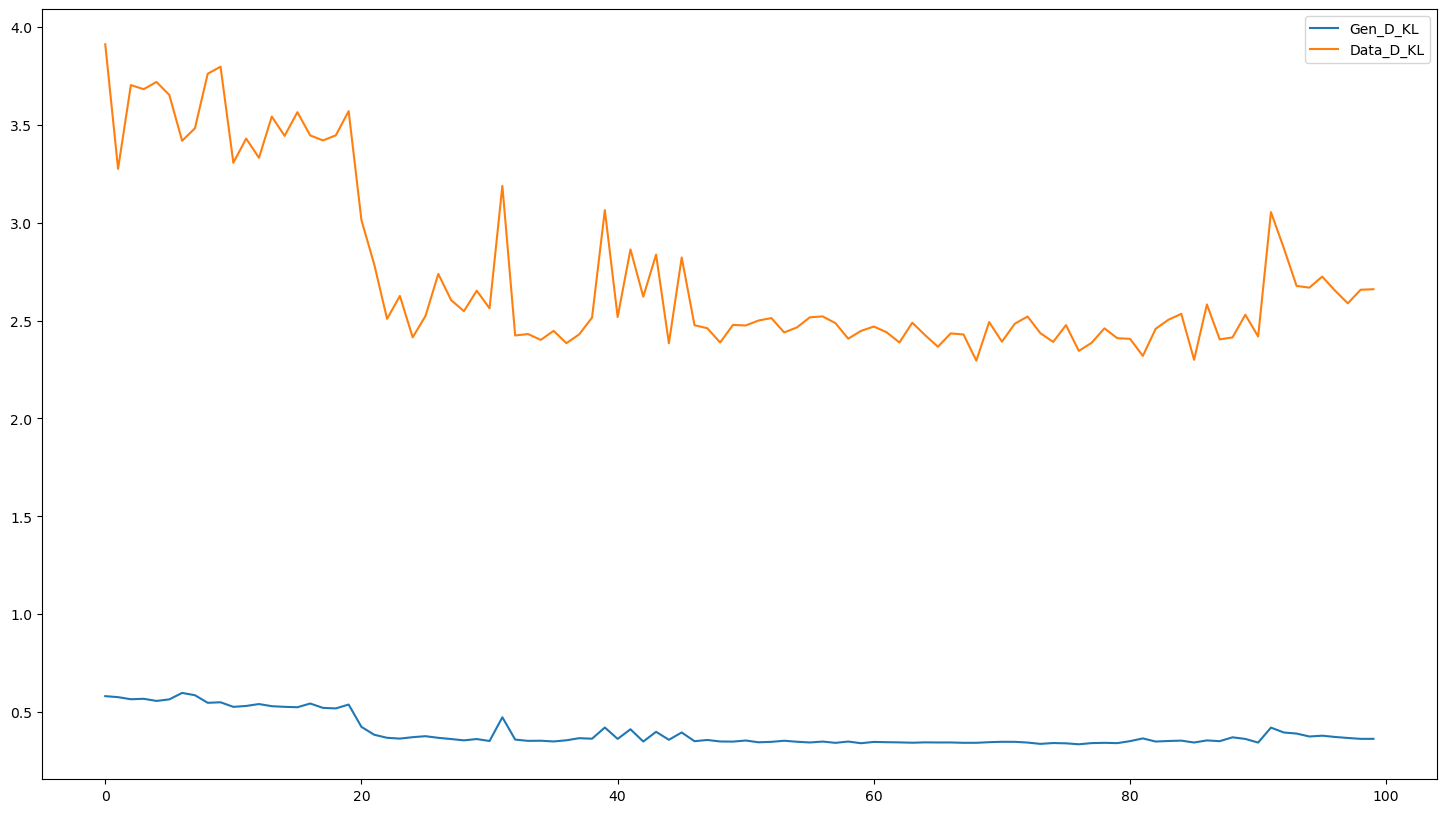

In [609]:
Analytic = Analytic_MIM_well_formed
fig, ax = plt.subplots(figsize=(18, 10))
ax.plot(np.array(Analytic['Gen_D_KL']),label = 'Gen_D_KL')
ax.plot(np.array(Analytic['Data_D_KL']),label = 'Data_D_KL')
ax.legend()
plt.show()

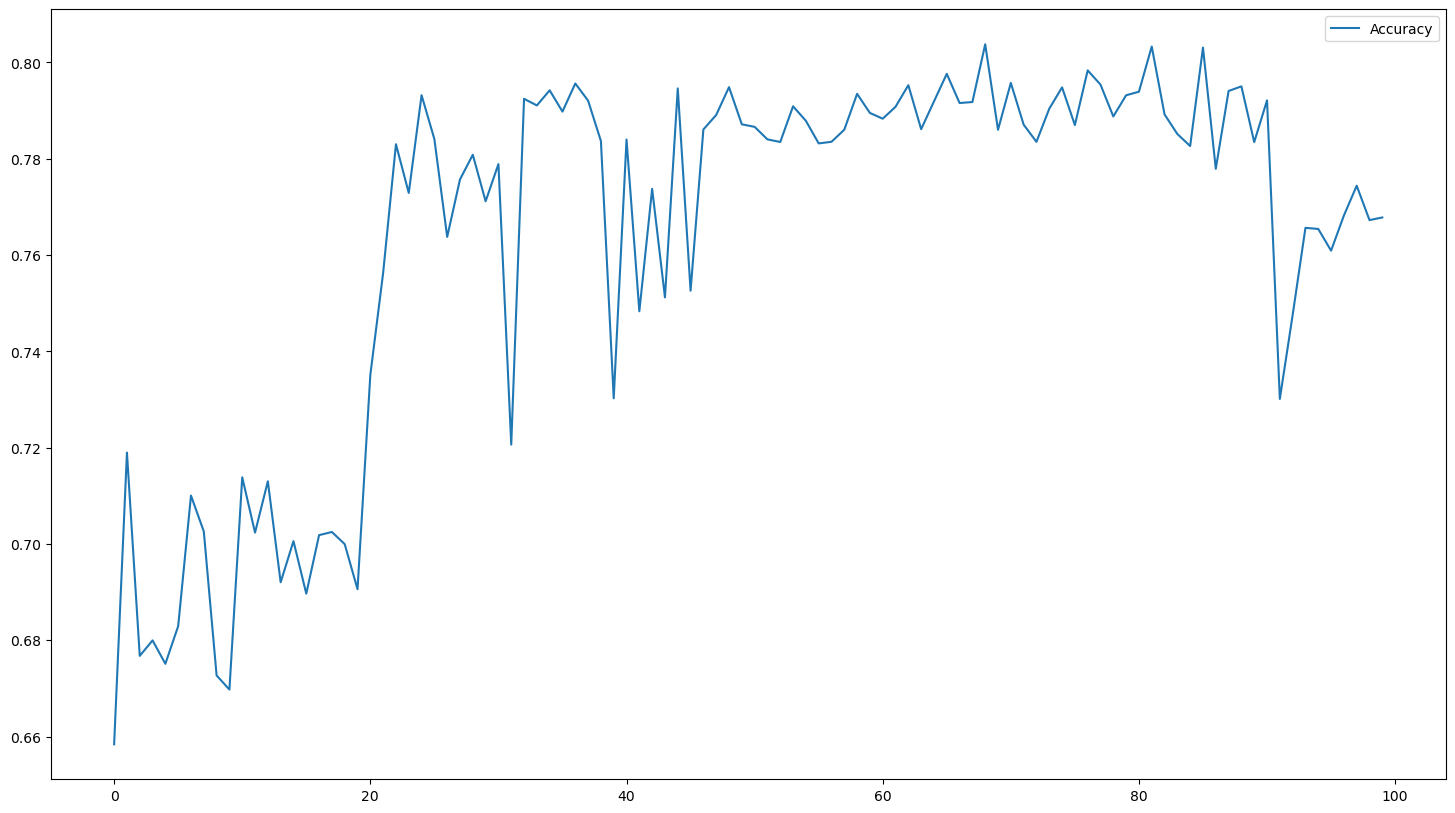

In [610]:
fig, ax = plt.subplots(figsize=(18, 10))
ax.plot(np.array(Analytic['Accuracy']),label = 'Accuracy')
ax.legend()
plt.show()

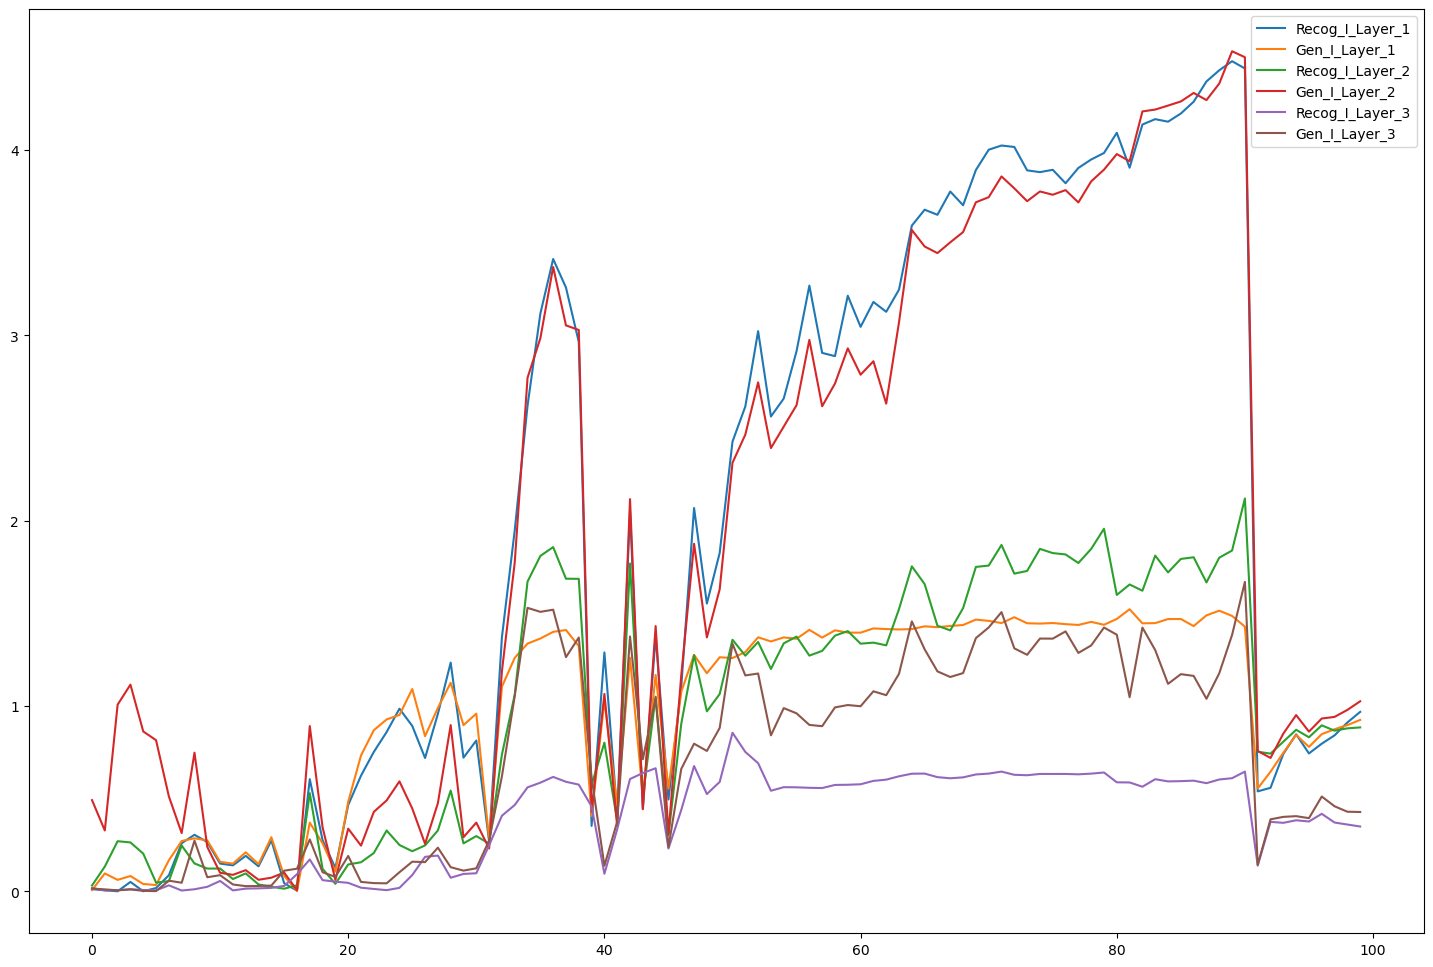

In [611]:
fig, ax = plt.subplots(figsize=(18, 12))
for i in range(1,n_layer-1):
    ax.plot(np.array(Analytic['Recog_I_Layer_'+str(i)]),label = 'Recog_I_Layer_'+str(i))
    ax.plot(np.array(Analytic['Gen_I_Layer_'+str(i)]),label = 'Gen_I_Layer_'+str(i))
ax.legend()
plt.show()

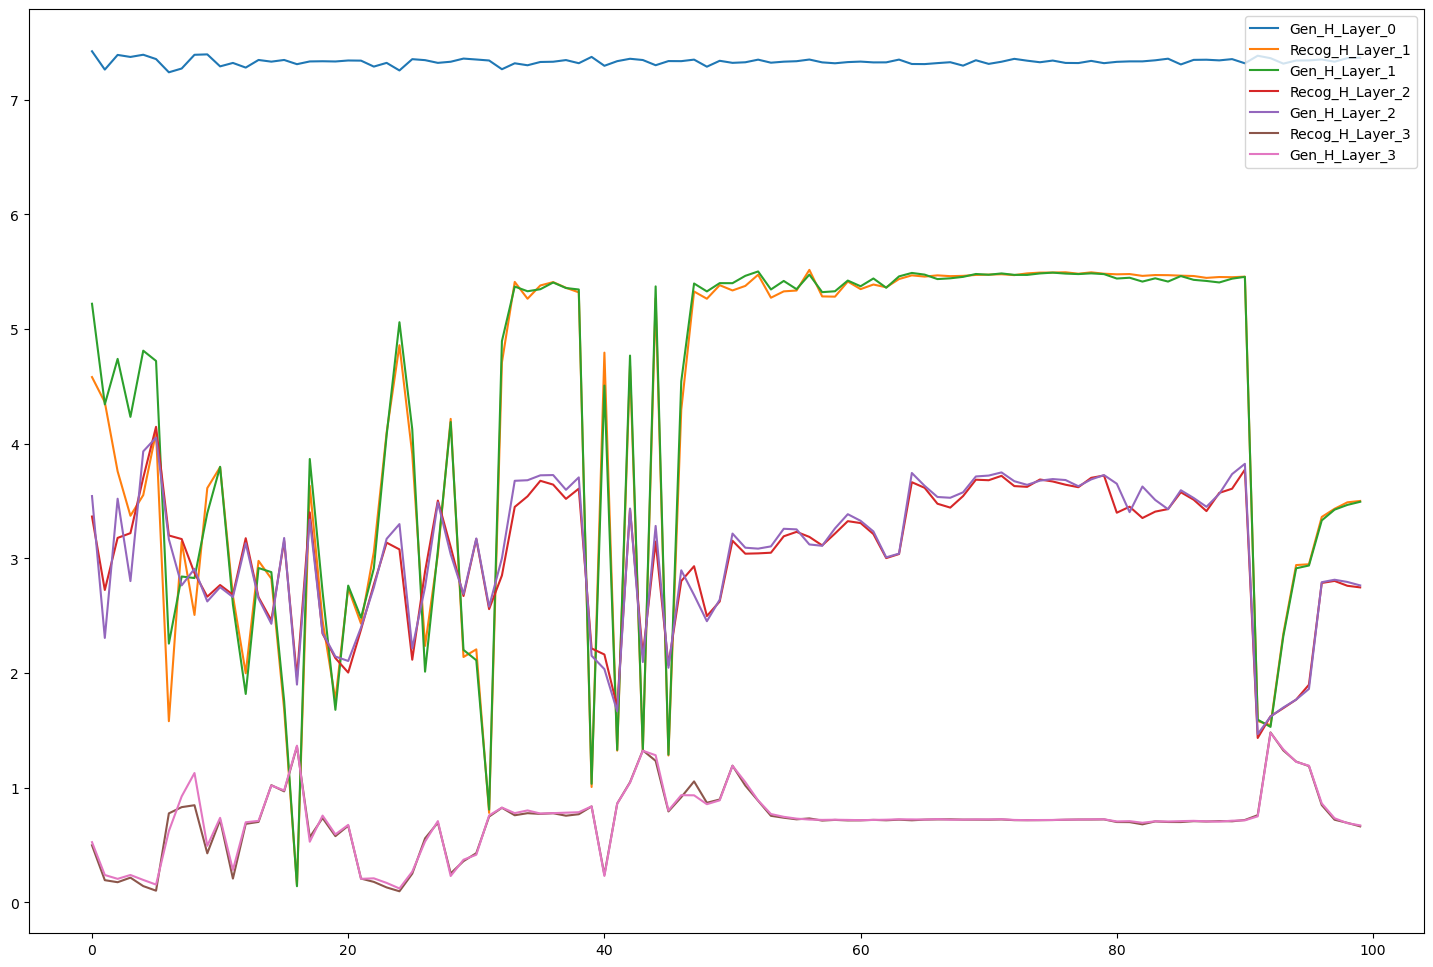

In [612]:
fig, ax = plt.subplots(figsize=(18, 12))
ax.plot(np.array(Analytic['Gen_H_Layer_0']),label = 'Gen_H_Layer_0')
for i in range(1,n_layer-1):
    ax.plot(np.array(Analytic['Recog_H_Layer_'+str(i)]),label = 'Recog_H_Layer_'+str(i))
    ax.plot(np.array(Analytic['Gen_H_Layer_'+str(i)]),label = 'Gen_H_Layer_'+str(i))
ax.legend()
plt.show()

In [613]:
n_dz[0,:-1] * np.log(2)

tensor([8.3178, 5.5452, 4.1589, 2.0794])

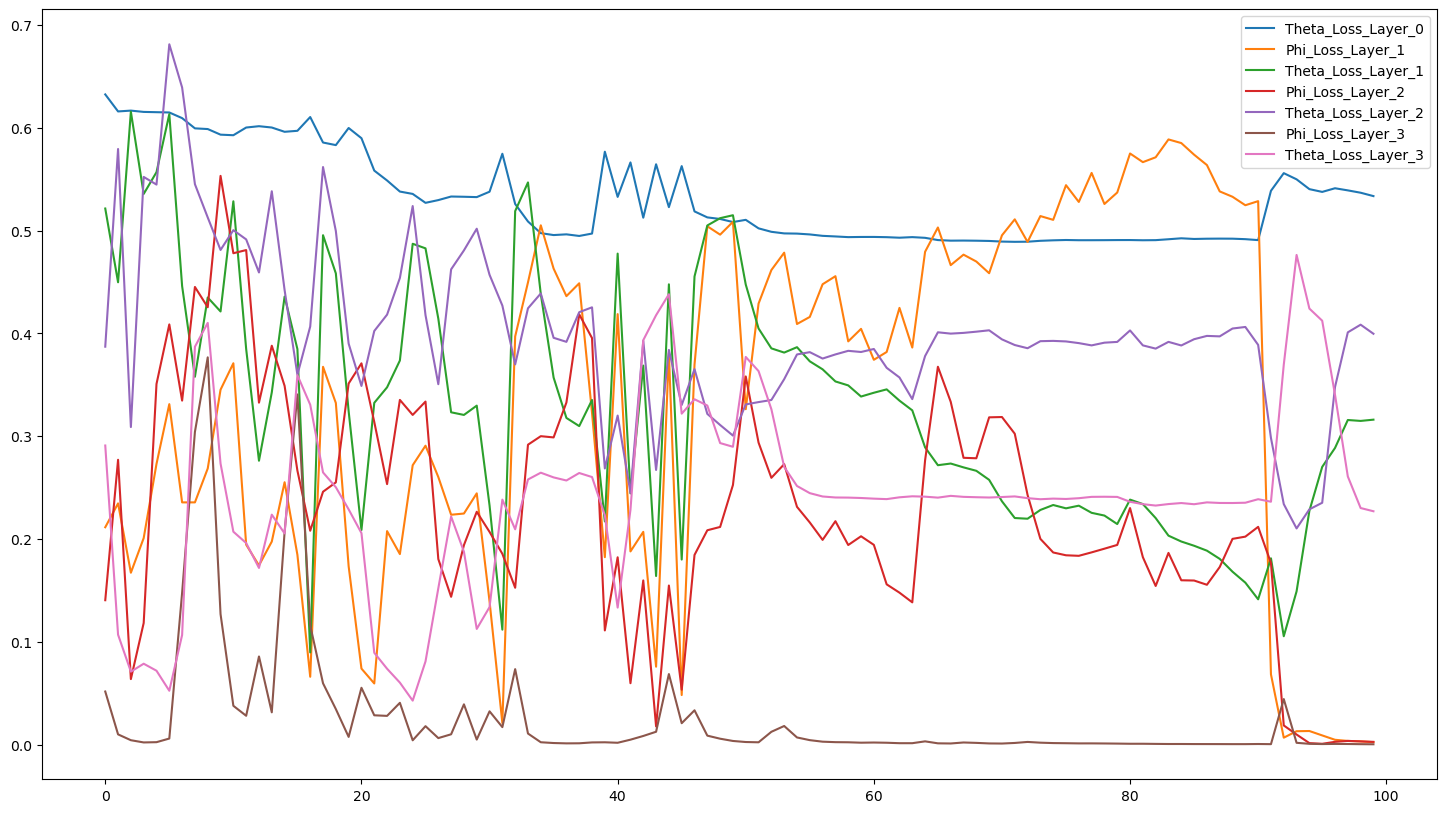

In [614]:
fig, ax = plt.subplots(figsize=(18, 10))
ax.plot(np.array(Analytic['Theta_Loss_Layer_'+str(0)]),label = 'Theta_Loss_Layer_'+str(0))
for i in range(1,n_layer-1):
    ax.plot(np.array(Analytic['Phi_Loss_Layer_'+str(i)]),label = 'Phi_Loss_Layer_'+str(i))
    ax.plot(np.array(Analytic['Theta_Loss_Layer_'+str(i)]),label = 'Theta_Loss_Layer_'+str(i))
ax.legend()
plt.show()

In [615]:
wake_dict = wake_sample(Phi,data,dev)
Dist_wake = {}
for key in wake_dict:
    sample_w = wake_dict[key]
    values_g,counts_g = torch.unique(decimalize(sample_w,dev),return_counts=True)
    dist = torch.zeros(2**sample_w.shape[0],device=dev)
    dist[values_g]=counts_g/sample_w.shape[1]
    Dist_wake[key] = dist

In [616]:
sleep_dict = sleep_sample(Theta,gen_batch_size,dev)
Dist_sleep = {}
for key in sleep_dict:
    sample_s = sleep_dict[key]
    values_g,counts_g = torch.unique(decimalize(sample_s,dev),return_counts=True)
    dist = torch.zeros(2**sample_s.shape[0],device=dev)
    dist[values_g]=counts_g/sample_s.shape[1]
    Dist_sleep[key] = dist

In [600]:
# torch.unique(decimalize(sleep_dict['Layer_3'],dev),return_counts=True)

In [601]:
# binarilize([128],8,dev)

In [617]:
data_dcm = decimalize(well_formed_set,dev)
gen_dcm = decimalize(sleep_dict['Layer_0'],dev)
gen_dcm

tensor([2710, 2623, 2773,  ..., 2938, 2818, 2525], device='cuda:0')

Layer 0 Data_dist D_KL: 2.6758
Layer 0 Gen_dist D_KL: 0.3628
Layer 1 Recognition Distribution D_KL: 0.3714 H(Y): 3.5007 H(Y|X): 2.5325 I_XY: 0.9682
Layer 1 Generative  Distribution D_KL: 0.0988 H(Y): 3.4899 H(Y|X): 6.4442 I_XY: 0.9229
Layer 2 Recognition Distribution D_KL: 0.0784 H(Y): 2.7441 H(Y|X): 1.8581 I_XY: 0.8861
Layer 2 Generative  Distribution D_KL: 0.0331 H(Y): 2.765 H(Y|X): 2.4649 I_XY: 1.025
Layer 3 Recognition Distribution D_KL: 0.0239 H(Y): 0.6637 H(Y|X): 0.3127 I_XY: 0.351
Layer 3 Generative  Distribution D_KL: 0.0039 H(Y): 0.671 H(Y|X): 2.3374 I_XY: 0.4276


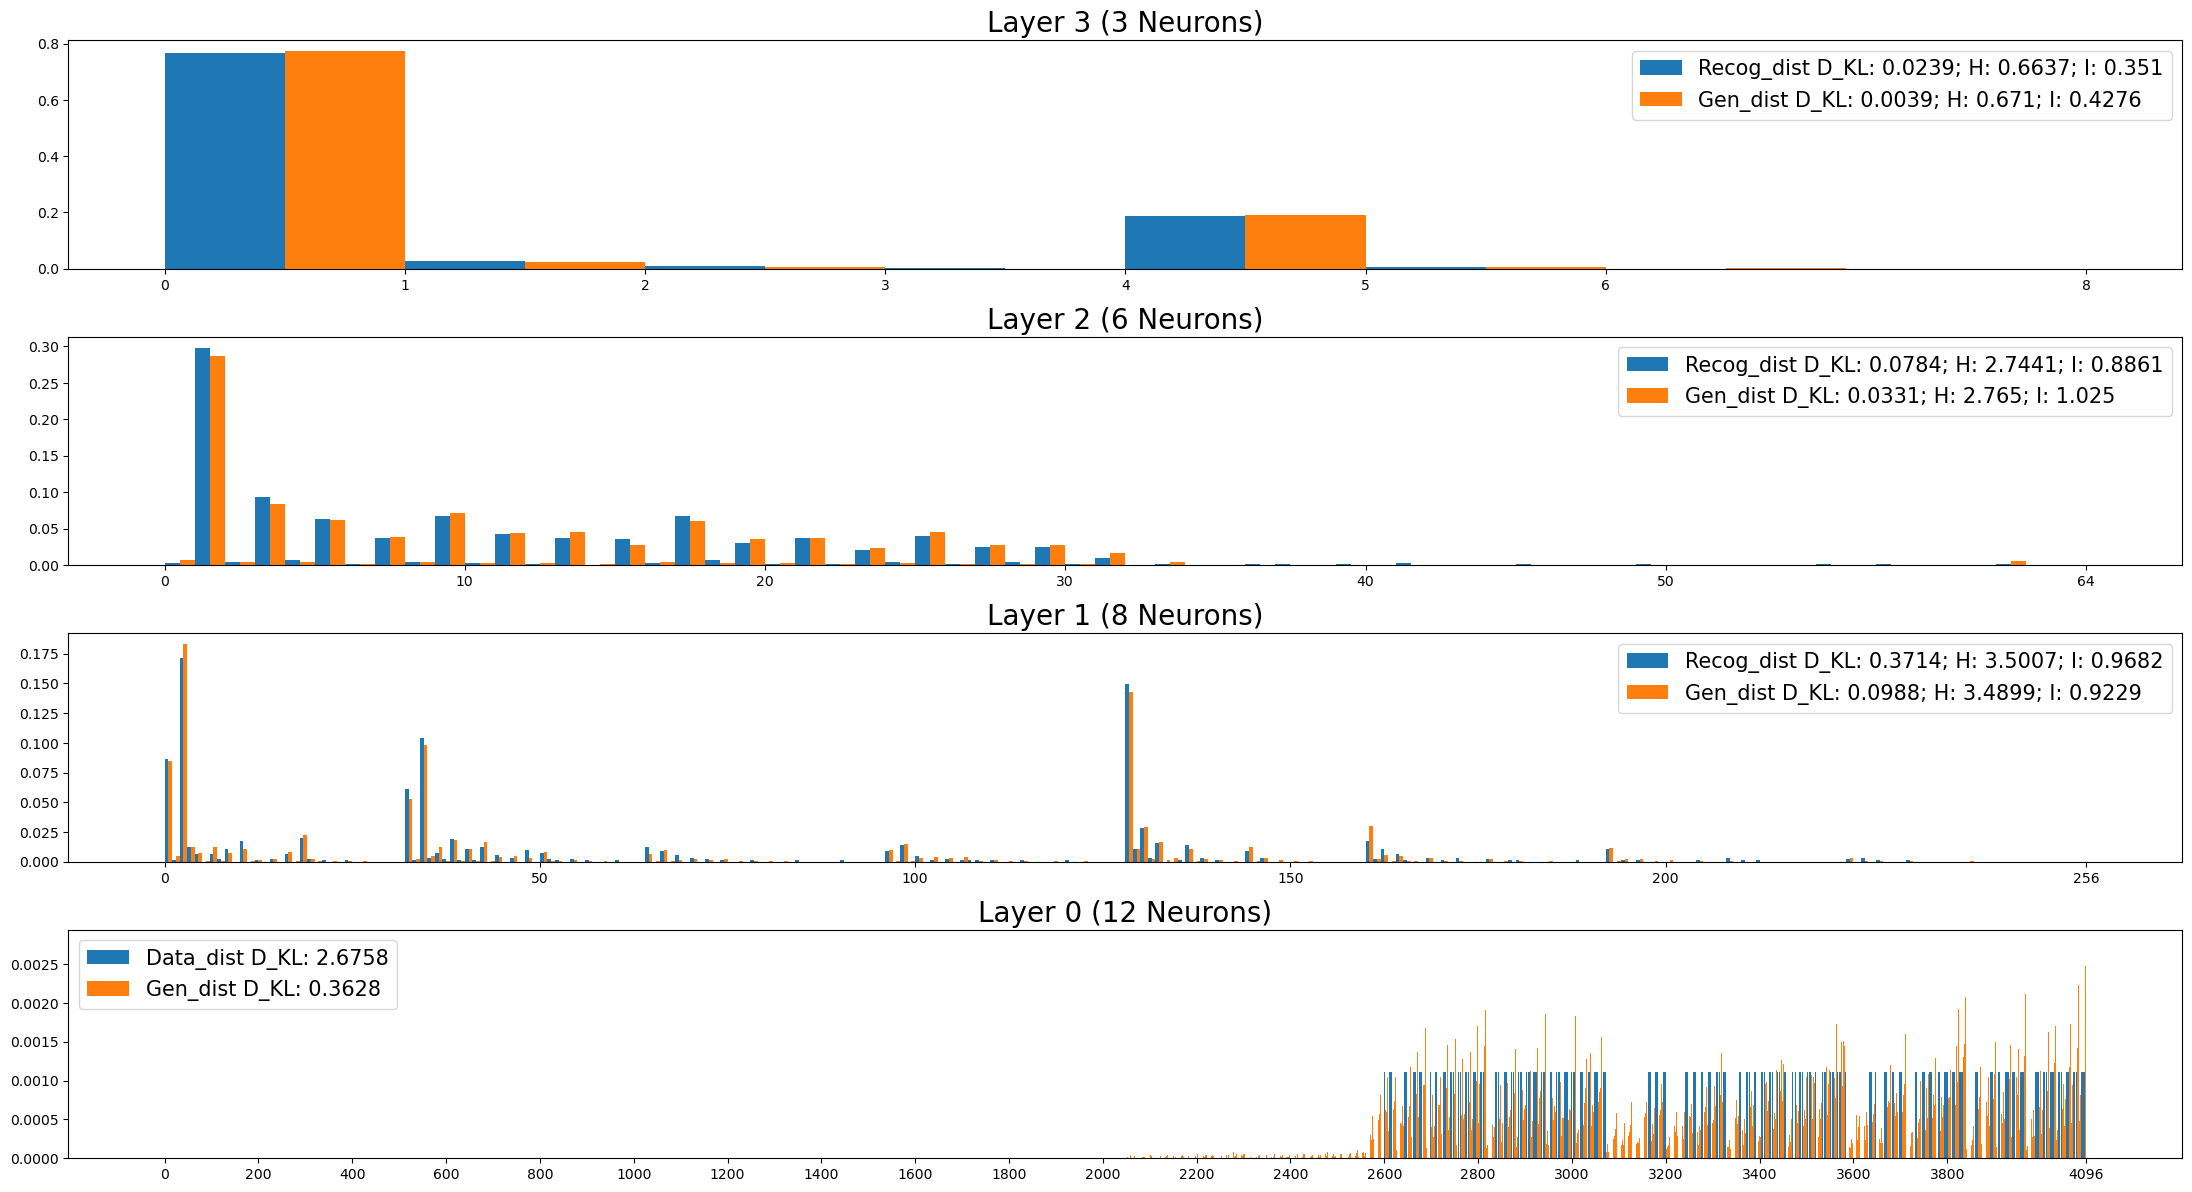

In [618]:
fig_ct, ax_ct = plt.subplots(n_layer-1, 1, figsize=(22, 12))
# fig_ct.suptitle("Layer-wise Categorical Distribution",fontsize=25)
H_Y_w, I_w = wake_entropy(Phi,data.repeat(1,50),dev)
H_Y_s, I_s = sleep_entropy(Theta,gen_batch_size,dev)
H_Y_w = H_Y_w.to('cpu').numpy()
I_w = I_w.to('cpu').numpy()
H_Y_s = H_Y_s.to('cpu').numpy()
I_s = I_s.to('cpu').numpy()

for i in range(n_layer-1):
    dist_w = Dist_wake['Layer_'+str(i)]
    dist_s = Dist_sleep['Layer_'+str(i)]
    D_KL_w = KL_divergence(dist_s,dist_w).item()
    D_KL_s = KL_divergence(dist_w,dist_s).item()
    
    if i > 0:
        print("Layer "+str(i), "Recognition Distribution D_KL: "+str(np.around(D_KL_w,4)),\
          "H(Y): "+str(np.around(H_Y_w[i-1],4)), "H(Y|X): "+str(np.around(H_Y_w[i-1]-I_w[i-1],4)),"I_XY: "+str(np.around(I_w[i-1],4)))
        print("Layer "+str(i),"Generative  Distribution D_KL: "+str(np.around(D_KL_s,4)),\
          "H(Y): "+str(np.around(H_Y_s[i],4)), "H(Y|X): "+str(np.around(H_Y_s[i-1]-I_s[i-1],4)),"I_XY: "+str(np.around(I_s[i-1],4)))
        ax_ct[n_layer-2-i].bar(np.arange(2**n_dz[0,i]),dist_w.to('cpu').numpy(),width=0.5,align='edge',\
                           label = "Recog_dist D_KL: " + str(np.around(D_KL_w,4))+"; H: "+ \
                               str(np.around(H_Y_w[i-1],4))+ "; I: "+ str(np.around(I_w[i-1],4)))
        ax_ct[n_layer-2-i].bar(np.arange(2**n_dz[0,i])+0.5,dist_s.to('cpu').numpy(),width=0.5,align='edge',\
                          label = "Gen_dist D_KL: " + str(np.around(D_KL_s,4))+"; H: "+ \
                               str(np.around(H_Y_s[i],4))+ "; I: "+ str(np.around(I_s[i-1],4)))
    else:
        print("Layer "+str(i), "Data_dist D_KL: "+str(np.around(D_KL_w,4)))
        ax_ct[n_layer-2-i].bar(np.arange(2**n_dz[0,i]),dist_w.to('cpu').numpy(),width=0.5,align='edge',\
                           label = "Data_dist D_KL: " + str(np.around(D_KL_w,4)))
        
        print("Layer "+str(i), "Gen_dist D_KL: "+str(np.around(D_KL_s,4)))
        ax_ct[n_layer-2-i].bar(np.arange(2**n_dz[0,i])+0.5,dist_s.to('cpu').numpy(),width=0.5,align='edge',\
                           label = "Gen_dist D_KL: " + str(np.around(D_KL_s,4)))

    ax_ct[n_layer-2-i].set_title("Layer "+str(i)+" ("+ str(n_dz[0,i].item())+" Neurons)",fontsize=20)
    ax_ct[n_layer-2-i].legend(fontsize=15)
    
    x_lim = 2**(n_dz[0,n_layer-2-i])
    if i==0:
        xtick = np.arange(0,x_lim)
    elif i==1:
        xtick = np.arange(0,x_lim,10)
    elif i==2:
        xtick = np.arange(0,x_lim,50)
    elif i==3:
        xtick = np.arange(0,x_lim,200)
    elif i==4:
        xtick = np.arange(0,x_lim,1000)    
    xtick[-1] = x_lim
    ax_ct[i].set(xticks=xtick)
    

plt.tight_layout(pad=1)    
plt.show()

In [604]:
H_Y_w

array([5.452449  , 3.606868  , 0.70667404], dtype=float32)

In [585]:
I_w

array([3.9843965 , 1.9565607 , 0.64045036], dtype=float32)

In [586]:
H_Y_s

array([7.319568 , 5.477563 , 3.723989 , 0.7243564], dtype=float32)

In [587]:
I_s

array([1.4392247, 3.8913257, 1.4235342], dtype=float32)

Layer 0 Data_dist D_KL: 0.0044
Layer 0 Gen_dist D_KL: 0.0031
Layer 1 Recognition Distribution D_KL: 0.0063 H(Y): 5.4723 H(Y|X): 1.5798 I_XY: 3.8925
Layer 1 Generative  Distribution D_KL: 0.0063 H(Y): 5.4781 H(Y|X): 4.0134 I_XY: 1.4647
Layer 2 Recognition Distribution D_KL: 0.0043 H(Y): 3.6861 H(Y|X): 1.935 I_XY: 1.7511
Layer 2 Generative  Distribution D_KL: 0.0042 H(Y): 3.7106 H(Y|X): -0.0034 I_XY: 3.7139
Layer 3 Recognition Distribution D_KL: 0.0029 H(Y): 0.7211 H(Y|X): 0.0894 I_XY: 0.6317
Layer 3 Generative  Distribution D_KL: 0.0019 H(Y): 0.7231 H(Y|X): -0.6445 I_XY: 1.3676


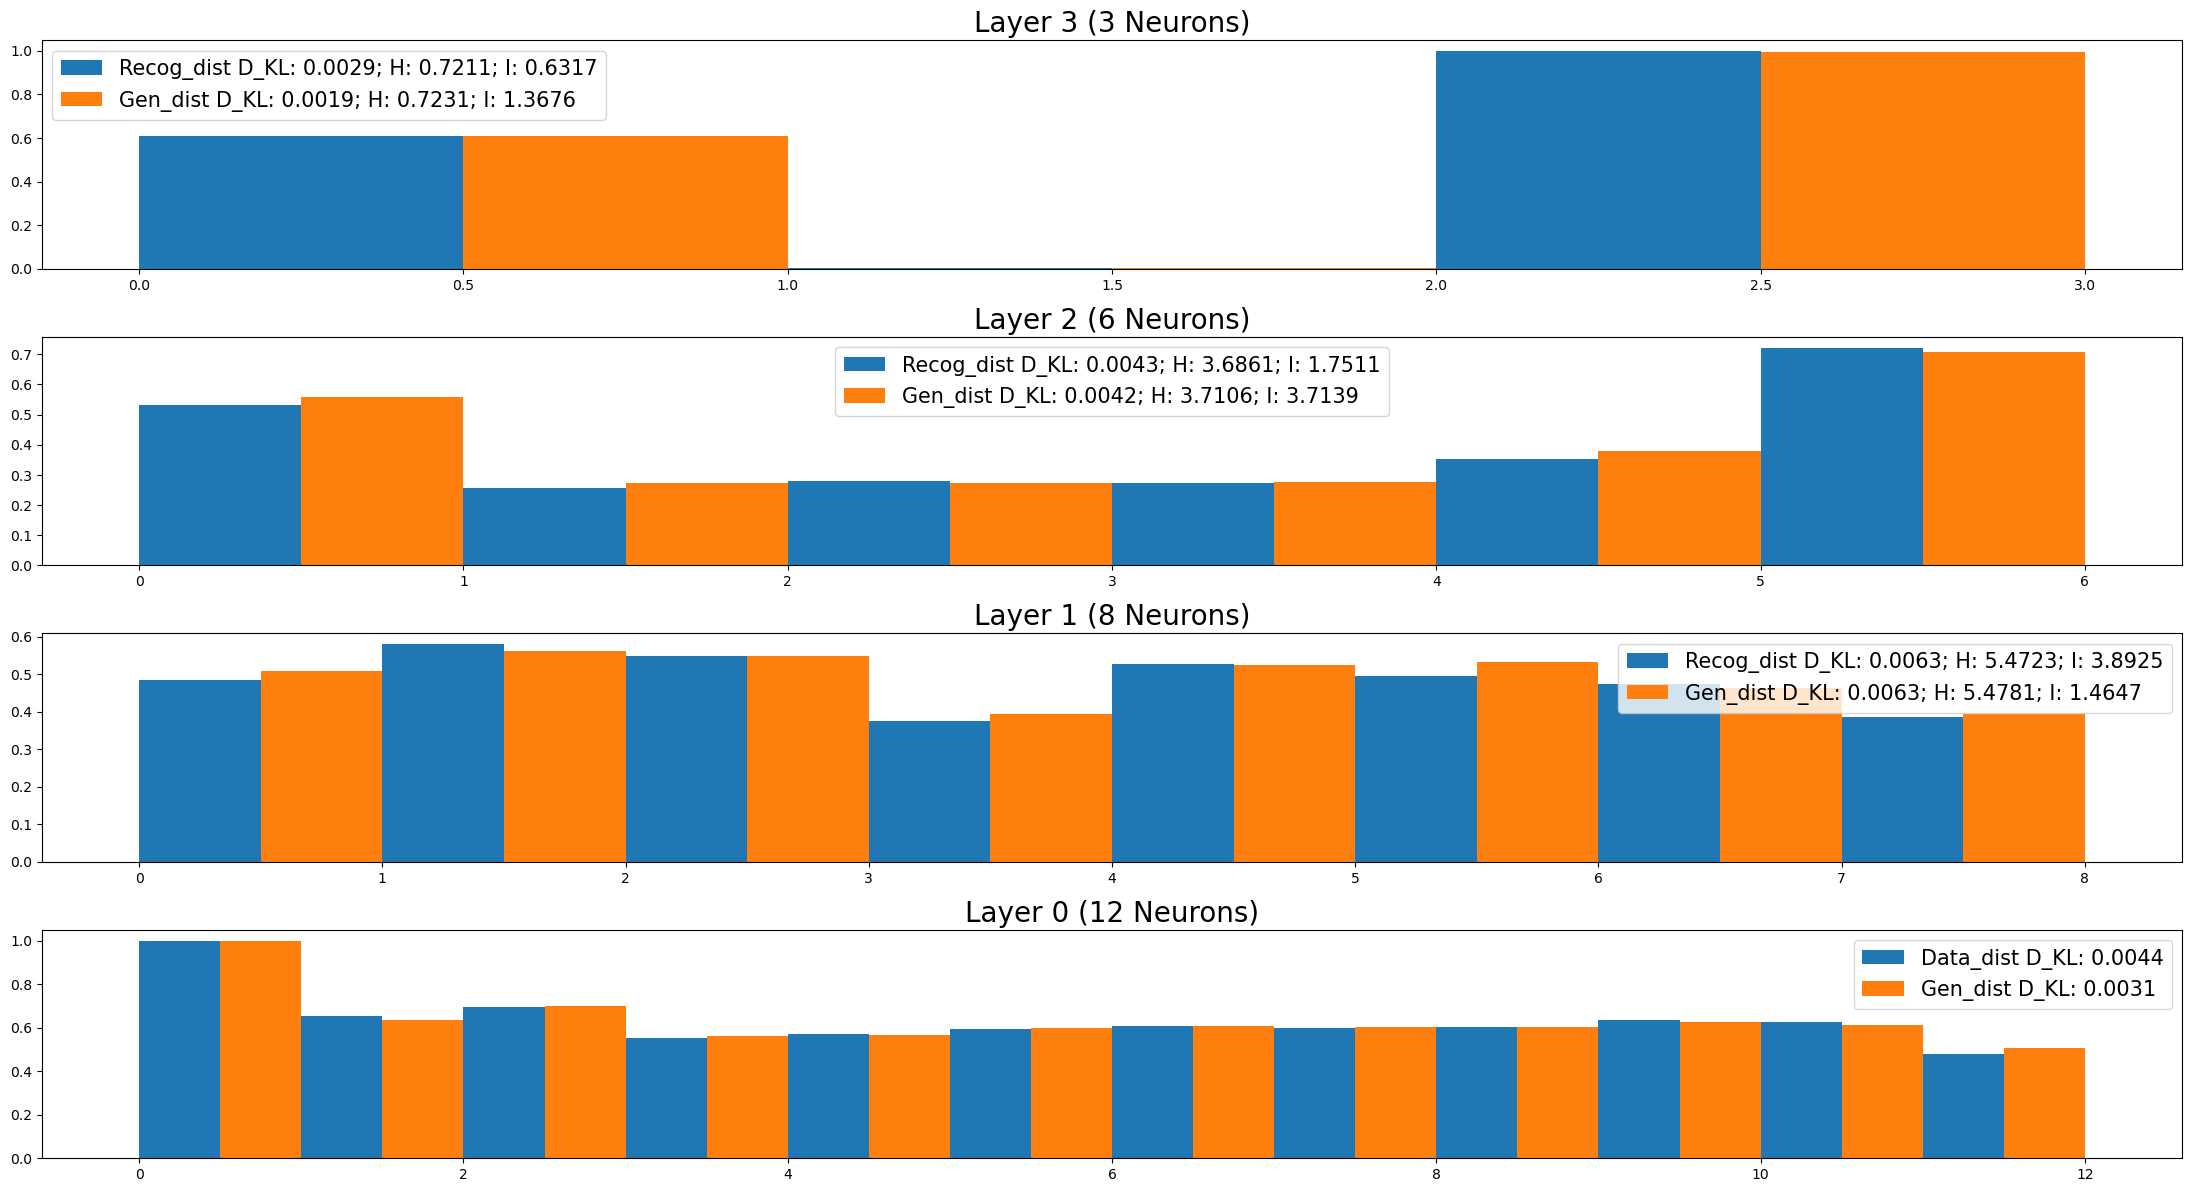

In [567]:
fig_ct, ax_ct = plt.subplots(n_layer-1, 1, figsize=(22, 12))
# fig_ct.suptitle("Layer-wise Factorial Distribution",fontsize=25)
H_Y_w, I_w = wake_entropy(Phi,data.repeat(1,50),dev)
H_Y_s, I_s = sleep_entropy(Theta,gen_batch_size,dev)
H_Y_w = H_Y_w.to('cpu').numpy()
I_w = I_w.to('cpu').numpy()
H_Y_s = H_Y_s.to('cpu').numpy()
I_s = I_s.to('cpu').numpy()

for i in range(n_layer-1):
    dist_w = wake_dict['Layer_'+str(i)].sum(axis=1)/wake_dict['Layer_'+str(i)].shape[1]
    dist_s = sleep_dict['Layer_'+str(i)].sum(axis=1)/sleep_dict['Layer_'+str(i)].shape[1]
    D_KL_w = KL_divergence_bernoulli(dist_s,dist_w).item()
    D_KL_s = KL_divergence_bernoulli(dist_w,dist_s).item()
    
    if i > 0:
        print("Layer "+str(i), "Recognition Distribution D_KL: "+str(np.around(D_KL_w,4)),\
          "H(Y): "+str(np.around(H_Y_w[i-1],4)), "H(Y|X): "+str(np.around(H_Y_w[i-1]-I_w[i-1],4)),"I_XY: "+str(np.around(I_w[i-1],4)))
        print("Layer "+str(i),"Generative  Distribution D_KL: "+str(np.around(D_KL_s,4)),\
          "H(Y): "+str(np.around(H_Y_s[i],4)), "H(Y|X): "+str(np.around(H_Y_s[i]-I_s[i-1],4)),"I_XY: "+str(np.around(I_s[i-1],4)))
        ax_ct[n_layer-2-i].bar(np.arange(n_dz[0,i]),dist_w.to('cpu').numpy(),width=0.5,align='edge',\
                           label = "Recog_dist D_KL: " + str(np.around(D_KL_w,4))+"; H: "+ \
                               str(np.around(H_Y_w[i-1],4))+ "; I: "+ str(np.around(I_w[i-1],4)))
        ax_ct[n_layer-2-i].bar(np.arange(n_dz[0,i])+0.5,dist_s.to('cpu').numpy(),width=0.5,align='edge',\
                          label = "Gen_dist D_KL: " + str(np.around(D_KL_s,4))+"; H: "+ \
                               str(np.around(H_Y_s[i],4))+ "; I: "+ str(np.around(I_s[i-1],4)))
    else:
        print("Layer "+str(i), "Data_dist D_KL: "+str(np.around(D_KL_w,4)))
        ax_ct[n_layer-2-i].bar(np.arange(n_dz[0,i]),dist_w.to('cpu').numpy(),width=0.5,align='edge',\
                           label = "Data_dist D_KL: " + str(np.around(D_KL_w,4)))
        
        print("Layer "+str(i), "Gen_dist D_KL: "+str(np.around(D_KL_s,4)))
        ax_ct[n_layer-2-i].bar(np.arange(n_dz[0,i])+0.5,dist_s.to('cpu').numpy(),width=0.5,align='edge',\
                           label = "Gen_dist D_KL: " + str(np.around(D_KL_s,4)))

    ax_ct[n_layer-2-i].set_title("Layer "+str(i)+" ("+ str(n_dz[0,i].item())+" Neurons)",fontsize=20)
    ax_ct[n_layer-2-i].legend(fontsize=15)

plt.tight_layout(pad=1)    
plt.show()

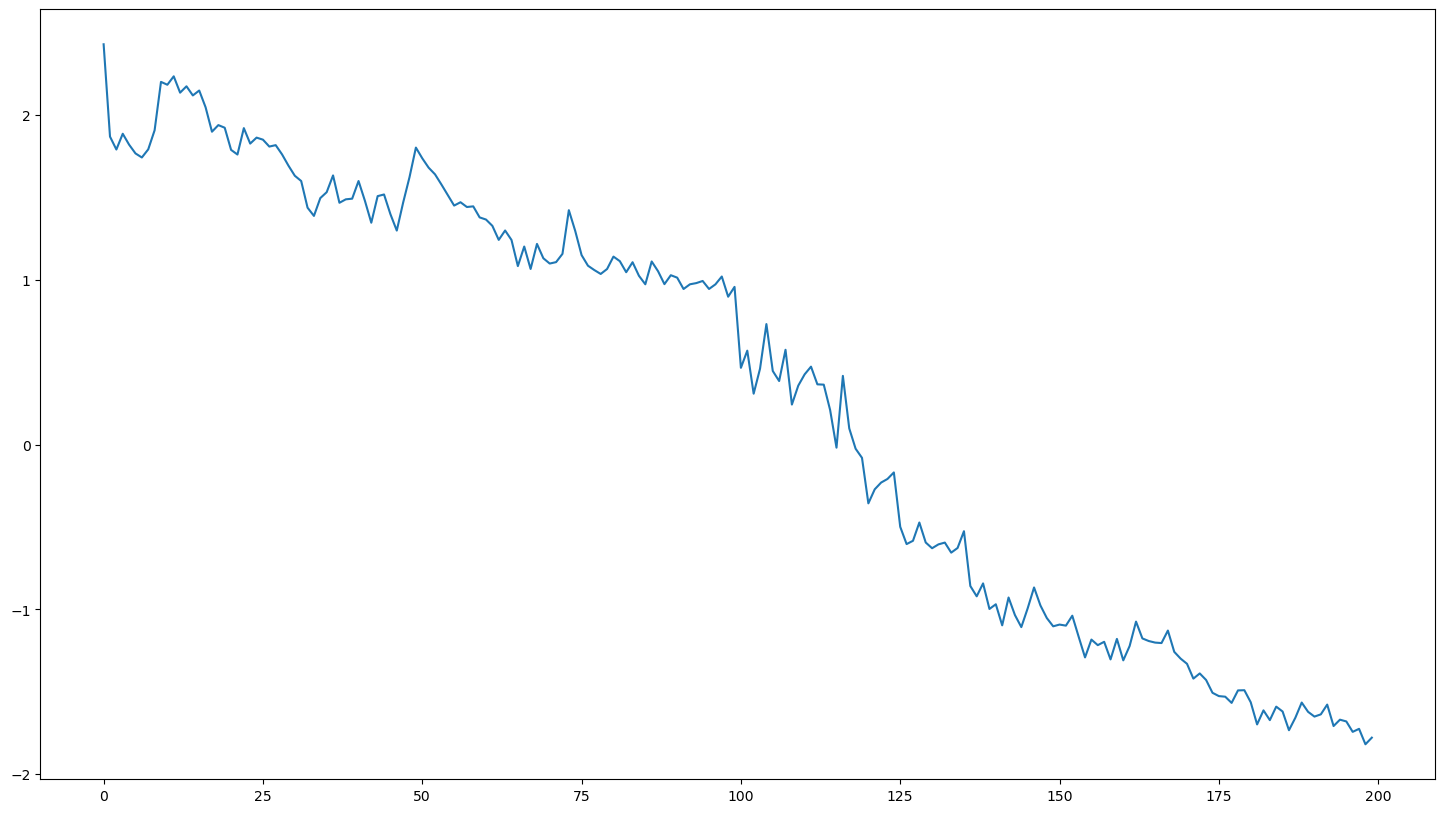

In [300]:
# normalized loss
Loss = 2*np.array(Analytic['Theta_Loss_Layer_'+str(0)])-((np.array(Analytic['Gen_I_Layer_1']))+ \
                                                         np.array(Analytic['Gen_H_Layer_0']))/structure[0,0]
for i in range(1,n_layer-2):
    Loss += np.array(Analytic['Phi_Loss_Layer_'+str(i)]) + np.array(Analytic['Theta_Loss_Layer_'+str(i)]) - \
    (np.array(Analytic['Gen_I_Layer_'+str(i+1)])+np.array(Analytic['Recog_I_Layer_'+str(i)])+
    np.array(Analytic['Gen_H_Layer_'+str(i)])+np.array(Analytic['Recog_H_Layer_'+str(i)]))/structure[0,i]/2
Loss += np.array(Analytic['Phi_Loss_Layer_'+str(n_layer-2)]) + np.array(Analytic['Theta_Loss_Layer_'+str(n_layer-2)]) - \
        np.array(Analytic['Recog_I_Layer_'+str(n_layer-2)]+np.array(Analytic['Gen_H_Layer_'+str(n_layer-2)])+ \
                 np.array(Analytic['Recog_H_Layer_'+str(n_layer-2)]))/structure[0,n_layer-2]/2
fig, ax = plt.subplots(figsize=(18, 10))
ax.plot(Loss)
plt.show()

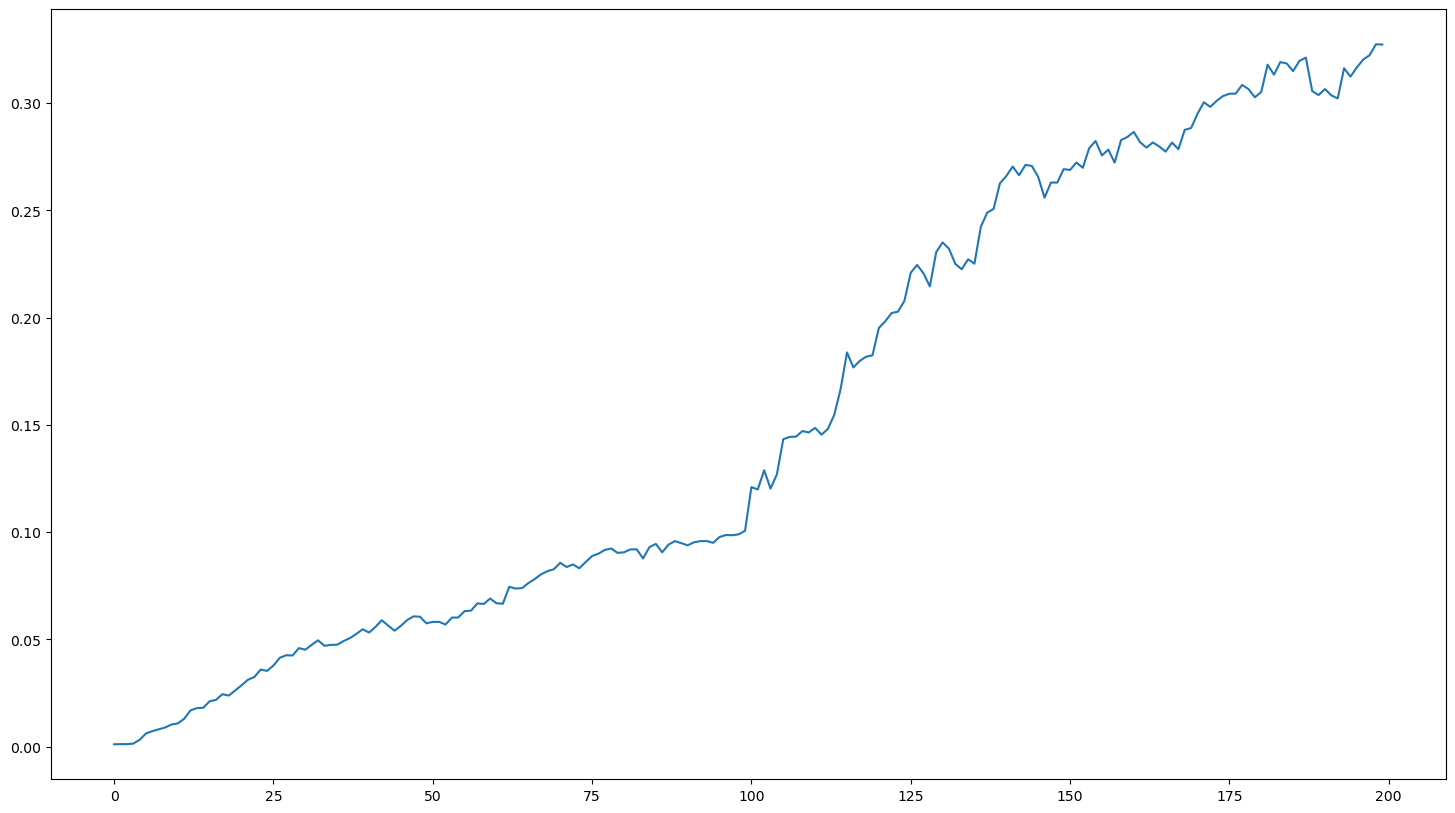

In [301]:
# normalized mutual information
I = np.array(Analytic['Recog_I_Layer_'+str(1)]) + np.array(Analytic['Gen_I_Layer_'+str(1)])
H = np.array(Analytic['Recog_H_Layer_'+str(1)]) + np.array(Analytic['Gen_H_Layer_'+str(0)]) + \
    np.array(Analytic['Gen_H_Layer_'+str(1)]) + np.array(Analytic['Gen_H_Layer_'+str(0)])
for i in range(1,n_layer-2):
    I += np.array(Analytic['Recog_I_Layer_'+str(i+1)]) + np.array(Analytic['Gen_I_Layer_'+str(i+1)])
    H += np.array(Analytic['Recog_H_Layer_'+str(i+1)]) + np.array(Analytic['Recog_H_Layer_'+str(i)]) + \
    np.array(Analytic['Gen_H_Layer_'+str(i+1)]) + np.array(Analytic['Gen_H_Layer_'+str(i)])
fig, ax = plt.subplots(figsize=(18, 10))
ax.plot(I/H)
plt.show()